In [37]:
### Paquetes y Base de datos

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from scipy.stats import genpareto, invgamma, lognorm, gaussian_kde
import scipy.stats as st
import os

df = pd.read_csv(r"..\data\clean\datos_limpios.csv")
df = df.drop(columns=['Unnamed: 0'])

In [38]:
df

ano provincia         canton      latitud   longitud         total  \
0     2005   Cartago       Alvarado   9.91708244 -83.809449  2.062700e+07   
1     2005   Cartago       Alvarado   9.91708244 -83.809449  5.363636e+08   
2     2005   Cartago       Alvarado   9.91708244 -83.809449  6.210540e+06   
3     2005   Cartago       Alvarado   9.91708244 -83.809449  5.440422e+06   
4     2005   Cartago       Alvarado   9.91708244 -83.809449  3.254603e+07   
...    ...       ...            ...          ...        ...           ...   
2346  2022  San José  Pérez Zeledón  9.384718038 -83.706217  5.013908e+09   
2347  2022  San José  Pérez Zeledón  9.384718038 -83.706217  6.000000e+05   
2348  2023  Alajuela     San Carlos  10.32272126 -84.430822  2.635822e+09   
2349  2023  Alajuela     San Carlos  10.32272126 -84.430822  1.500000e+08   
2350  2023  Alajuela     San Carlos  10.32272126 -84.430822  2.310000e+09   

            categoria  
0     INFRAESTRUCTURA  
1              SOCIAL  
2               OTROS  
3               OTROS  
4              SOCIAL  
...               ...  
2346            OTROS  
2347           SOCIAL  
2348  INFRAESTRUCTURA  
2349  INFRAESTRUCTURA  
2350          HÍDRICO  

[2351 rows x 7 columns]

# Funciones

In [39]:
def umbral_optimo (datos, categoria = None, provincia = None):

    if categoria is not None and provincia is None:
        datos_cat = np.array(datos[datos['categoria'] == categoria]['total'])
        titulo = f" | Categoría : {categoria}"
    if provincia is not None and categoria is None:
        datos_cat = np.array(datos[datos['provincia'] == provincia]['total'])
        titulo = f" | Provincia : {provincia}"
    if provincia is None and categoria is None:
        datos_cat = np.array(datos['total'])
        titulo = ''

    umbrales = np.linspace(np.percentile(datos_cat, 50), np.percentile(datos_cat, 99), 1000)
    mrl = []
    umbrales_ok = []

    for u in umbrales:
        exc = datos_cat[datos_cat > u] - u
        prop = len(exc)/len(datos_cat)
        if 0.05 <= prop <= 0.20:
            mrl.append(exc.mean() if len(exc) else np.nan)
            umbrales_ok.append(u)
        else:
            mrl.append(np.nan)
            umbrales_ok.append(np.nan)

    mrl = np.array(mrl)
    valid = ~np.isnan(mrl)
    t = umbrales[valid]
    mrl = mrl[valid]

    if len(mrl) < 3:
        # fallback: percentil 90 si hay poca señal
        u_fallback = np.percentile(datos_cat, 90)
        print("[Aviso] MRL con pocos puntos válidos. Uso fallback p90 =", f"{u_fallback:,.2f}")
        return float(u_fallback)

    # Variabilidad local
    diffs = np.abs(np.diff(mrl))

    # Seleccionar posición donde menor variación
    idx_best = np.argmin(diffs)
    umbral_opt = t[idx_best + 1]  # +1 porque diff reduce dimensión en 1

    proporcion = len(datos_cat[datos_cat>umbral_opt])/len(datos_cat)

    if categoria is not None and provincia is None:
        print('La proporción de datos para ', categoria, 'es ', f"{proporcion:.3f}")
    if provincia is not None and categoria is None:
        print('La proporción de datos para ', provincia, 'es ', f"{proporcion:.3f}")
    

    # Gráfico diagnóstico
    plt.figure(figsize=(8,5))
    plt.plot(t, mrl, marker='o', markersize=4, label="MRL")
    plt.axvline(umbral_opt, color="red", linestyle=":", 
                label=f"Umbral óptimo: {umbral_opt:.2f}")
    plt.xlabel("Umbral u")
    plt.ylabel("Mean Residual Life")
    plt.title("Selección de Umbral con MRL" + titulo)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return float(umbral_opt)

def histogramas(datos, u, categoria=None, provincia = None):

    if categoria is not None and provincia is None:
        datos_cat = datos[datos['categoria'] == categoria]['total']
        titulo_cat = f" | Categoría: {categoria}"
    elif provincia is not None and categoria is None:
        datos_cat = datos[datos['provincia'] == provincia]['total']
        titulo_cat = f" | Provincia: {provincia}"
    elif provincia is None and categoria is None:
        datos_cat = datos['total']
        titulo_cat = ""


    plt.figure(figsize=(10,5))
    sns.histplot(datos_cat, bins=60, log_scale=True, color='firebrick')
    plt.title("Histograma de pérdidas totales" + titulo_cat)
    plt.xlabel("Pérdida Total (log)")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    cuerpo = datos_cat[datos_cat <= u]
    plt.figure(figsize=(10,5))
    sns.histplot(cuerpo, bins=60, log_scale=True, color='royalblue')
    plt.title(f"Cuerpo (≤ {u:.2f})" + titulo_cat)
    plt.xlabel("Pérdida Total (log)")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    cola = datos_cat[datos_cat > u]
    plt.figure(figsize=(10,5))
    sns.histplot(cola, bins=60, log_scale=True, color='darkorange')
    plt.title(f"Cola (> {u:.2f})" + titulo_cat)
    plt.xlabel("Pérdida Total (log)")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

def guardar_resultados_csv(nombre, res, carpeta="resultados_csv"):
    os.makedirs(carpeta, exist_ok=True)

    u_opt = float(res["u_opt"])
    p_u   = float(res["p_u"])
    
    body_model = res["body_model"]
    tail_model = res["tail_model"]

    # Guardar body samples
    body_samples = pd.DataFrame(
        res["body_samples"],
        columns=[f"{body_model}_param{i+1}"
                for i in range(res["body_samples"].shape[1])]
    )
    body_samples["iteration"]  = range(len(body_samples))
    body_samples["model_name"] = body_model
    body_samples["model_type"] = "body"
    body_samples["u_opt"]      = u_opt
    body_samples["p_u"]        = p_u
    body_samples["location"]   = nombre

    body_samples.to_csv(
        f"{carpeta}/{nombre}_body.csv", index=False
    )

    # Guardar tail samples si existen
    if res["tail_samples"] is not None:
        tail_samples = pd.DataFrame(
            res["tail_samples"],
            columns=[f"{tail_model}_param{i+1}"
                    for i in range(res["tail_samples"].shape[1])]
        )
        tail_samples["iteration"]  = range(len(tail_samples))
        tail_samples["model_name"] = tail_model
        tail_samples["model_type"] = "tail"
        tail_samples["u_opt"]      = u_opt
        tail_samples["p_u"]        = p_u
        tail_samples["location"]   = nombre

        tail_samples.to_csv(
            f"{carpeta}/{nombre}_tail.csv", index=False
        )

In [40]:
def valida_gamma(theta, data):
    alpha, beta = theta
    return alpha > 0 and beta > 0 and np.all(data > 0)

def valida_weibull(theta, data):
    k, lam = theta
    return k > 0 and lam > 0 and np.all(data > 0)

def valida_lognorm(theta, data):
    mu, sigma = theta
    return (sigma > 0) and np.all(data > 0)

def valida_fisk(theta, data):
    alpha, beta = theta
    return (alpha > 0) and (beta > 0) and np.all(data > 0)

def valida_gpd(theta, data):
    xi, sigma = theta
    if sigma <= 0: 
        return False
    return np.all(1.0 + xi*data/sigma > 0)

def valida_burr(theta, exc):
    c, k, lam = theta
    return c > 0 and k > 0 and lam > 0

def valida_pareto(theta, exc):
    a, y0 = theta
    return a > 0 and y0 > 0

def valida_logn_tail(theta, x, u):
    mu, s = theta
    return s > 0 and np.all(x > u)

In [41]:
def logpost_gamma(theta, data):
    alpha, beta = theta
    if alpha <= 0 or beta <= 0 or np.any(data <= 0):
        return -np.inf
    ll = np.sum(st.gamma.logpdf(data, a=alpha, scale=1.0/beta))
    lp = st.expon.logpdf(alpha, scale=10) + st.expon.logpdf(beta, scale=10)
    return ll + lp

def logpost_weibull(theta, data):
    k, lam = theta
    if k <= 0 or lam <= 0 or np.any(data <= 0):
        return -np.inf
    ll = np.sum(st.weibull_min.logpdf(data, c=k, scale=lam))
    lp = st.expon.logpdf(k, scale=10) + st.expon.logpdf(lam, scale=10)
    return ll + lp

def logpost_lognorm(theta, data):
    mu, sigma = theta
    if sigma <= 0 or np.any(data <= 0):
        return -np.inf
    ll = np.sum(st.lognorm.logpdf(data, s=sigma, scale=np.exp(mu)))
    lp = st.norm.logpdf(mu, 0, 10) + st.halfnorm.logpdf(sigma, scale=5)
    return ll + lp

def logpost_fisk(theta, data):
    alpha, beta = theta
    if alpha <= 0 or beta <= 0 or np.any(data <= 0):
        return -np.inf
    ll = np.sum(st.fisk.logpdf(data, c=alpha, scale=beta))
    lp = st.expon.logpdf(alpha, scale=10) + st.expon.logpdf(beta, scale=10)
    return ll + lp

def logpost_gpd(theta, data):
    xi, sigma = theta
    if sigma <= 0 or np.any(1.0 + xi*data/sigma <= 0):
        return -np.inf
    ll = np.sum(st.genpareto.logpdf(data, c=xi, scale=sigma))
    lp = st.norm.logpdf(xi, 0, 1) + st.expon.logpdf(sigma, scale=1)
    return ll + lp

def logpost_burr(theta, exc):
    c, k, lam = theta
    if c <= 0 or k <= 0 or lam <= 0:
        return -np.inf
    return (
        np.sum(st.burr12.logpdf(exc, c=c, d=k, scale=lam))
        + st.expon.logpdf(c, scale=10)
        + st.expon.logpdf(k, scale=10)
        + st.expon.logpdf(lam, scale=10)
    )

def logpost_pareto(theta, exc):
    a, y0 = theta
    if a <= 0 or y0 <= 0:
        return -np.inf
    ll = np.sum(np.log(a) + a*np.log(y0) - (a+1)*np.log(exc + y0))
    lp = st.expon.logpdf(a, scale=10) + st.expon.logpdf(y0, scale=10)
    return ll + lp

def logpost_logn_tail(theta, x, u):
    mu, s = theta
    if s <= 0 or np.any(x <= u):
        return -np.inf
    Z = 1 - st.lognorm.cdf(u, s=s, scale=np.exp(mu))
    if Z <= 0:
        return -np.inf
    return (
        np.sum(st.lognorm.logpdf(x, s=s, scale=np.exp(mu)) - np.log(Z))
        + st.norm.logpdf(mu, 0, 10)
        + st.halfnorm.logpdf(s, scale=5)
    )

def cdf_body_factory(model, params):
    if model == "Lognormal":
        mu, s = params
        return lambda x: st.lognorm.cdf(x, s=s, scale=np.exp(mu))
    if model == "Weibull":
        k, lam = params
        return lambda x: st.weibull_min.cdf(x, c=k, scale=lam)
    if model == "Gamma":
        a, b = params
        return lambda x: st.gamma.cdf(x, a=a, scale=1/b)
    if model == "Fisk":
        a, b = params
        return lambda x: st.fisk.cdf(x, c=a, scale=b)
    raise ValueError("Modelo de cuerpo no reconocido.")

In [42]:
def waic(log_lik_matrix):
    a = np.max(log_lik_matrix, axis=0, keepdims=True)
    lppd = np.sum(a + np.log(np.mean(np.exp(log_lik_matrix - a), axis=0, keepdims=True)))
    p_waic = np.sum(np.var(log_lik_matrix, axis=0, ddof=1))
    return -2*(lppd - p_waic)

def waic_gamma(samples, data):
    S = samples.shape[0]
    N = data.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        a, b = samples[s]
        ll[s] = st.gamma.logpdf(data, a=a, scale=1.0/b)
    return waic(ll), ll

def waic_weibull(samples, data):
    S = samples.shape[0]; N = data.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        k, lam = samples[s]
        ll[s] = st.weibull_min.logpdf(data, c=k, scale=lam)
    return waic(ll), ll

def waic_lognorm(samples, data):
    S, N = samples.shape[0], data.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        mu, sig = samples[s]
        ll[s] = st.lognorm.logpdf(data, s=sig, scale=np.exp(mu))
    return waic(ll), ll

def waic_fisk(samples, data):
    S, N = samples.shape[0], data.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        a, b = samples[s]
        ll[s] = st.fisk.logpdf(data, c=a, scale=b)
    return waic(ll), ll

def waic_gpd(samples, data):
    S = samples.shape[0]; N = data.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        xi, sigma = samples[s]
        ll[s] = st.genpareto.logpdf(data, c=xi, scale=sigma)
    return waic(ll), ll

def waic_burr(samples, exc):
    S, N = samples.shape[0], exc.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        c, k, lam = samples[s]
        ll[s] = st.burr12.logpdf(exc, c=c, d=k, scale=lam)
    return waic(ll), ll

def waic_pareto(samples, exc):
    S, N = samples.shape[0], exc.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        a, y0 = samples[s]
        ll[s] = np.log(a) + a*np.log(y0) - (a+1)*np.log(exc + y0)
    return waic(ll), ll

def waic_logn_tail(samples, x, u):
    S, N = samples.shape[0], x.shape[0]
    ll = np.empty((S, N))
    for s in range(S):
        mu, sig = samples[s]
        Z = 1 - st.lognorm.cdf(u, s=sig, scale=np.exp(mu))
        ll[s] = st.lognorm.logpdf(x, s=sig, scale=np.exp(mu)) - np.log(Z)
    return waic(ll), ll

def dic_from_ll(log_lik_matrix):
    # elpd = E_s[-log L] y -logL at mean se aproxima con el promedio de columnas del máximo a posteriori aproximado
    elpd = -np.mean(np.sum(log_lik_matrix, axis=1))
    # aproximación de -logL en el "promedio" usando truco log-mean-exp
    a = np.max(log_lik_matrix, axis=0, keepdims=True)
    lppd = np.sum(a + np.log(np.mean(np.exp(log_lik_matrix - a), axis=0, keepdims=True)))
    # p_D ≈ 2*(lppd - E_s[logL])
    p_D = 2*(lppd - (-elpd))
    return 2*elpd + p_D

def ks_ad_test(data, cdf_fn):
    data = np.sort(data)
    # KS
    ks_p = st.kstest(data, lambda t: cdf_fn(t)).pvalue
    # AD (versión corregida: suma, no media)
    F = np.clip(cdf_fn(data), 1e-12, 1-1e-12)
    n = len(data); i = np.arange(1, n+1)
    AD = -n - np.sum((2*i-1)*(np.log(F) + np.log(1 - F[::-1])))/n
    return ks_p, AD

In [43]:
def metro(data, logpost, inicial, prop, n=20000, validator=None, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    d = len(inicial)
    theta = np.zeros((n, d))
    theta[0] = inicial
    acept = 0

    for i in range(1, n):
        propuesta = theta[i-1] + rng.normal(0, prop, d)

        if validator is not None and not validator(propuesta, data):
            theta[i] = theta[i-1]
            continue

        lp_new = logpost(propuesta, data)
        lp_old = logpost(theta[i-1], data)

        log_alpha = lp_new - lp_old
        if np.log(rng.random()) < log_alpha:
            theta[i] = propuesta
            acept += 1
        else:
            theta[i] = theta[i-1]

    return theta, acept/(n-1)

def traceplot(samples, names=None, burn=0):
    if names is None:
        names = [f"θ{i+1}" for i in range(samples.shape[1])]
    num_params = samples.shape[1]
    fig, axes = plt.subplots(num_params, 1, figsize=(12, 3*num_params))
    if num_params == 1:
        axes = [axes]
    for i in range(num_params):
        axes[i].plot(samples[burn:, i], linewidth=0.7)
        axes[i].set_title(f"Trayectoria del parámetro: {names[i]}")
        axes[i].set_xlabel("Iteración")
        axes[i].set_ylabel(names[i])
        axes[i].grid(True, linestyle=":", alpha=0.5)
    plt.tight_layout()
    plt.show()

def traceplot_conjunto(samples, names=None, burn=0):
    if names is None:
        names = [f"θ{i+1}" for i in range(samples.shape[1])]
    S, d = samples.shape
    if d != 2:
        raise ValueError("El traceplot conjunto solo aplica a 2 parámetros (d=2)")
    samples_b = samples[burn:]
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    axes[0].plot(samples_b[:, 0], linewidth=0.7)
    axes[0].set_title(f"Trayectoria del parámetro: {names[0]}")
    axes[0].set_ylabel(names[0])
    axes[0].grid(True, linestyle=":", alpha=0.5)
    axes[1].plot(samples_b[:, 1], linewidth=0.7, color="tab:orange")
    axes[1].set_title(f"Trayectoria del parámetro: {names[1]}")
    axes[1].set_ylabel(names[1])
    axes[1].grid(True, linestyle=":", alpha=0.5)
    axes[2].plot(samples_b[:, 0], samples_b[:, 1], alpha=0.7)
    axes[2].set_title("Trayectoria conjunta en el espacio paramétrico")
    axes[2].set_xlabel(names[0])
    axes[2].set_ylabel(names[1])
    axes[2].grid(True, linestyle=":", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [44]:
def pipeline_categoria_consenso(df, categoria=None, provincia = None, n_iter=40000, burn=20000, seed=None):
    rng = np.random.default_rng(seed)
    if categoria is not None and provincia is None:
        print(f"Análisis por consenso para la categoría {categoria}")
    if provincia is not None and categoria is None:
        print(f"Análisis por consenso para la provincia {provincia}")


    # 1) UMBRAL + HISTOGRAMAS
    u_opt = umbral_optimo(df, categoria, provincia)
    print(f"Umbral óptimo: {u_opt:,.2f}")
    histogramas(df, u_opt, categoria, provincia)

    # Datos por categoría
    if categoria is not None and provincia is None:
        x = df.loc[df['categoria'] == categoria, 'total'].to_numpy()
        titulo_cat = f" | Categoría: {categoria}"

    if provincia is not None and categoria is None:
        x = df.loc[df['provincia'] == provincia, 'total'].to_numpy()
        titulo_cat = f" | Provincia: {provincia}"
    if provincia is None and categoria is None:
        x = df['total'].to_numpy()
        titulo_cat = ""
        
    x = x[x > 0]

    body = x[(x <= u_opt)]
    tail_x = x[(x > u_opt)]
    exc = tail_x - u_opt
    p_u = len(tail_x) / max(1, len(x))

    print(f"Tamaño cuerpo: {len(body)} | Tamaño cola: {len(tail_x)} | Proporción cola: {p_u:.3f}")
    if len(body) < 20:
        print("Advertencia: muy pocos datos en el cuerpo para una selección estable.")

    # 2) AJUSTE MCMC MODELOS DEL CUERPO + MÉTRICAS
    body_models = {
        "Gamma":     (logpost_gamma,   valida_gamma,   [2.0, 0.5],                                        [0.30, 0.20], waic_gamma),
        "Weibull":   (logpost_weibull, valida_weibull, [1.0, np.median(body) if len(body)>0 else 1.0],    [0.20, 0.20], waic_weibull),
        "Lognormal": (logpost_lognorm, valida_lognorm, [np.mean(np.log(body)), np.std(np.log(body))] if len(body)>0 else [0.0,1.0],
                                                                                                          [0.10, 0.05], waic_lognorm),
        "Fisk":      (logpost_fisk,    valida_fisk,    [1.0, np.median(body) if len(body)>0 else 1.0],    [0.20, 0.20], waic_fisk),
    }

    body_fit = {}
    body_metrics = []

    for name, (logp, valid, init, step, waic_fn) in body_models.items():
        print(f"\n Ajustando cuerpo: {name}")
        th, ar = metro(body, logp, inicial=init, prop=step, n=n_iter, validator=valid, rng=rng)
        th_b = th[burn:]
        print(f"Tasa de aceptación {name}: {ar:.2f}")
        body_fit[name] = th
        # WAIC y DIC sobre el CUERPO
        w, ll = waic_fn(th_b, body)
        d = dic_from_ll(ll)
        # KS y AD con parámetros medios
        pars_mean = th_b.mean(axis=0)
        ks_p, ad_stat = ks_ad_test(body, cdf_body_factory(name, pars_mean))
        body_metrics.append({
            "modelo": name,
            "WAIC": w,
            "DIC": d,
            "KS_p": ks_p,
            "AD": ad_stat,
            "pars_mean": pars_mean,
            "samples": th
        })

    bm = pd.DataFrame(body_metrics)
    bm["rank_WAIC"] = bm["WAIC"].rank(method="min")
    bm["rank_DIC"]  = bm["DIC"].rank(method="min")
    bm["rank_AD"]   = bm["AD"].rank(method="min")
    bm["rank_KS"]   = (-bm["KS_p"]).rank(method="min")
    bm["rank_mediana"] = bm[["rank_WAIC","rank_DIC","rank_AD","rank_KS"]].median(axis=1)

    idx_best = bm["rank_mediana"].idxmin()
    best_body = bm.loc[idx_best, "modelo"]
    tied = bm[bm["rank_mediana"] <= bm.loc[idx_best, "rank_mediana"] + 0.5]
    if "Lognormal" in list(tied["modelo"]):
        ln_row = bm[bm["modelo"]=="Lognormal"].iloc[0]
        best_row = bm.iloc[idx_best]
        if (ln_row["KS_p"] > best_row["KS_p"]) or (ln_row["AD"] < best_row["AD"]):
            best_body = "Lognormal"

    print("\nResumen métricas cuerpo:")
    print(bm[["modelo","WAIC","DIC","KS_p","AD","rank_mediana"]].sort_values("rank_mediana"))
    print(f"\nModelo seleccionado para el cuerpo: {best_body}")

    # Traceplot conjunto del cuerpo
    name_map = {"Gamma":["α","β"], "Weibull":["k","λ"], "Lognormal":["μ","σ"], "Fisk":["α","β"]}
    traceplot_conjunto(body_fit[best_body], names=name_map[best_body], burn=burn)

    # 3) AJUSTE Y CONSENSO DE COLA
    tail_results = []
    if len(exc) >= 10:
        tail_models = [
            ("GPD",      logpost_gpd,      valida_gpd,      [0.1, np.mean(exc)],         [0.15,0.50], waic_gpd),
            ("Burr",     logpost_burr,     valida_burr,     [1.0, 1.0, np.median(exc)],  [0.20,0.20,0.25], waic_burr),
            ("Pareto",   logpost_pareto,   valida_pareto,   [1.0, np.median(exc)],       [0.20,0.20],    waic_pareto),
            ("LN_tail",  logpost_logn_tail,lambda th,d: valida_logn_tail(th, d, u_opt),  [np.log(np.median(tail_x)), 1.0], [0.10,0.05], waic_logn_tail)
        ]
        for name, logp, valid, init, step, waic_fn in tail_models:
            print(f"\n Ajustando cola: {name}")
            data_tail = exc if name in ("GPD","Burr","Pareto") else tail_x
            validator_fn = valid if name != "LN_tail" else (lambda th, d: valid(th, tail_x))
            th, ar = metro(data_tail, lambda th, d: logp(th, d if name != "LN_tail" else tail_x, u_opt) if name == "LN_tail" else logp(th, d),
                           inicial=init, prop=step, n=n_iter, validator=validator_fn, rng=rng)
            print(f"Tasa aceptación {name}: {ar:.2f}")
            th_b = th[burn:]
            # WAIC
            w, ll = (waic_fn(th_b, data_tail) if name!="LN_tail" else waic_fn(th_b, tail_x, u_opt))
            # KS y AD sobre cola
            if name == "GPD":
                xi, sg = th_b.mean(axis=0)
                cdf_fn = lambda t: st.genpareto.cdf(t, c=xi, scale=sg); data_check = exc
            elif name == "Burr":
                c,k,lam = th_b.mean(axis=0)
                cdf_fn = lambda t: st.burr12.cdf(t, c=c, d=k, scale=lam); data_check = exc
            elif name == "Pareto":
                a, y0 = th_b.mean(axis=0)
                cdf_fn = lambda t: 1 - (y0/(t+y0))**a; data_check = exc
            else:  # LN_tail
                mu,sig = th_b.mean(axis=0)
                Zu = 1 - st.lognorm.cdf(u_opt, s=sig, scale=np.exp(mu))
                cdf_ln_trunc = lambda xx: (st.lognorm.cdf(xx, s=sig, scale=np.exp(mu)) -
                                           st.lognorm.cdf(u_opt, s=sig, scale=np.exp(mu))) / Zu
                cdf_fn = cdf_ln_trunc; data_check = tail_x
            ks_p, ad_stat = ks_ad_test(data_check, cdf_fn)
            tail_results.append({
                "modelo": name,
                "WAIC": w,
                "KS_p": ks_p,
                "AD": ad_stat,
                "samples": th
            })
        tm = pd.DataFrame(tail_results)
        tm["rank_WAIC"] = tm["WAIC"].rank(method="min")
        tm["rank_AD"] = tm["AD"].rank(method="min")
        tm["rank_KS"] = (-tm["KS_p"]).rank(method="min")
        tm["rank_mediana"] = tm[["rank_WAIC","rank_AD","rank_KS"]].median(axis=1)
        idx_best_t = tm["rank_mediana"].idxmin()
        best_tail = tm.loc[idx_best_t, "modelo"]
        tied = tm[tm["rank_mediana"] <= tm.loc[idx_best_t, "rank_mediana"] + 0.5]
        if "GPD" in list(tied["modelo"]) and best_tail != "GPD":
            gpd_row = tm[tm["modelo"]=="GPD"].iloc[0]
            best_row = tm.iloc[idx_best_t]
            if not ((best_row["KS_p"] - gpd_row["KS_p"] > 0.10) or (best_row["AD"] + 0.10 < gpd_row["AD"])):
                best_tail = "GPD"
        print("\nResumen métricas cola:")
        print(tm[["modelo","WAIC","KS_p","AD","rank_mediana"]].sort_values("rank_mediana"))
        print(f"\nModelo seleccionado para la cola: {best_tail}")
    else:
        print("Cola insuficiente. Se omite selección de cola.")
        best_tail = None
        tm = pd.DataFrame()

    # 4) GRÁFICO SPLICED CON JACOBIANO EN HISTOGRAMA LOG
    pars_body = bm.loc[bm["modelo"]==best_body, "pars_mean"].values[0]
    def body_pdf(xv):
        if best_body == "Gamma":
            a,b = pars_body; return (1-p_u)*st.gamma.pdf(xv, a=a, scale=1.0/b)
        if best_body == "Weibull":
            k,l = pars_body; return (1-p_u)*st.weibull_min.pdf(xv, c=k, scale=l)
        if best_body == "Lognormal":
            mu,s = pars_body; return (1-p_u)*st.lognorm.pdf(xv, s=s, scale=np.exp(mu))
        if best_body == "Fisk":
            a,b = pars_body; return (1-p_u)*st.fisk.pdf(xv, c=a, scale=b)
        raise ValueError("Modelo cuerpo desconocido")

    if best_tail is not None:
        th_tail = [r for r in tail_results if r["modelo"]==best_tail][0]["samples"][burn:]
        pars_tail = th_tail.mean(axis=0)
        def tail_pdf(xv):
            if best_tail == "GPD":
                xi, sg = pars_tail
                return p_u*st.genpareto.pdf(xv-u_opt, c=xi, scale=sg)
            if best_tail == "Burr":
                c,k,lam = pars_tail
                return p_u*st.burr12.pdf(xv-u_opt, c=c, d=k, scale=lam)
            if best_tail == "Pareto":
                a,y0 = pars_tail
                return p_u*(a * y0**a * (xv-u_opt + y0)**(-(a+1)))
            if best_tail == "LN_tail":
                mu,s = pars_tail
                Z = 1 - st.lognorm.cdf(u_opt, s=s, scale=np.exp(mu))
                return p_u * st.lognorm.pdf(xv, s=s, scale=np.exp(mu)) / Z
            raise ValueError("Modelo cola desconocido")
    else:
        def tail_pdf(xv):
            return np.zeros_like(xv)

    xx = np.logspace(np.log10(x.min()), np.log10(x.max()), 600)
    body_log = xx * body_pdf(xx)
    tail_log = xx * tail_pdf(xx)

    plt.figure(figsize=(12,6))
    sns.histplot(x, bins=60, stat="density", log_scale=True,
                 color="lightgray", edgecolor="black")
    plt.plot(xx, body_log, lw=2.3, label=f"Cuerpo: {best_body}")
    if best_tail is not None:
        m = xx > u_opt
        plt.plot(xx[m], tail_log[m], lw=2.3, ls="--", label=f"Cola: {best_tail}")
    plt.axvline(u_opt, color="black", linestyle=":", label="Umbral u")
    plt.title("Modelo spliced por consenso" + titulo_cat)
    plt.xlabel("Pérdida (escala log)")
    plt.ylabel("Densidad en log(X)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "u_opt": u_opt,
        "body_model": best_body,
        "body_table": bm,
        "tail_model": best_tail,
        "tail_table": tm,
        "p_u": p_u,
        "body_samples": body_fit[best_body],
        "tail_samples": (th_tail if best_tail is not None else None)
    }


Análisis por consenso para la categoría INFRAESTRUCTURA
La proporción de datos para  INFRAESTRUCTURA es  0.185


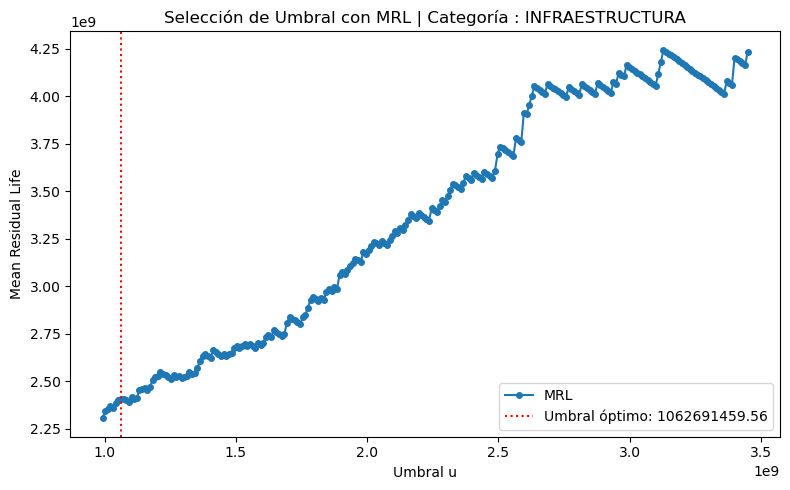

Umbral óptimo: 1,062,691,459.56


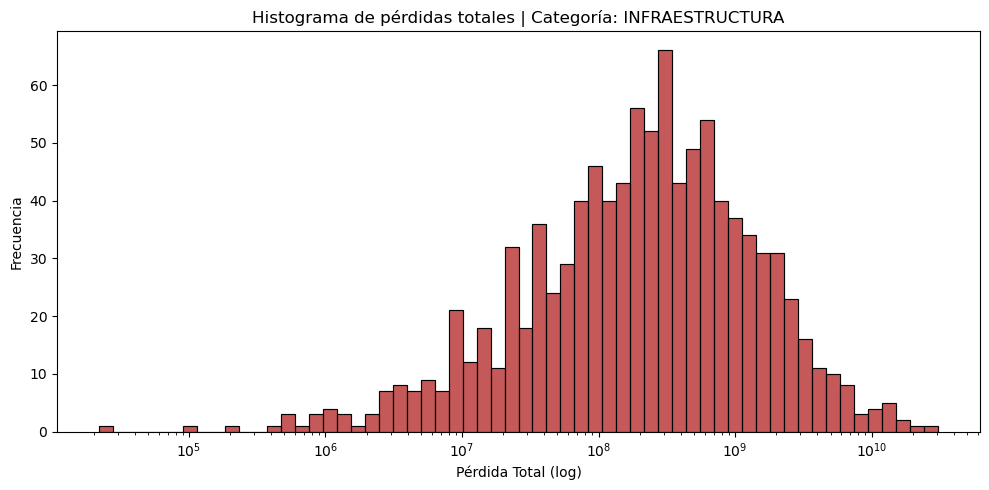

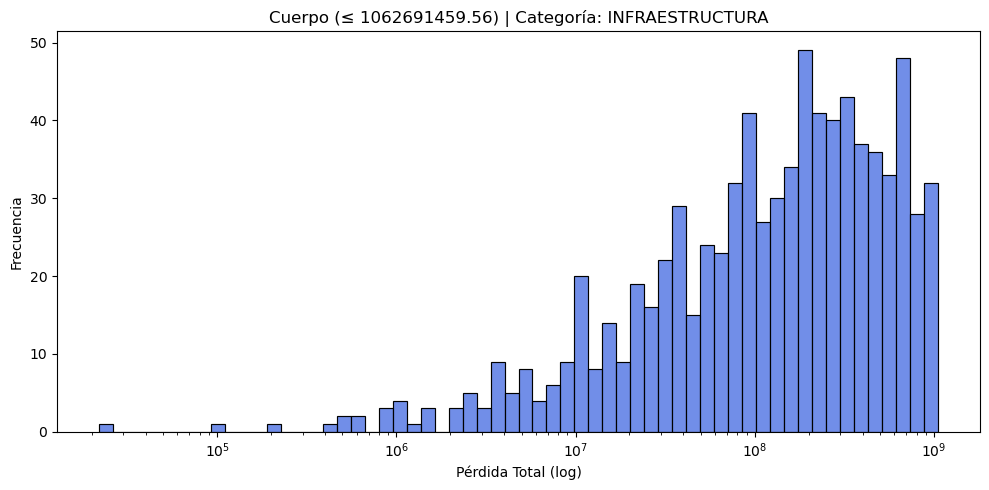

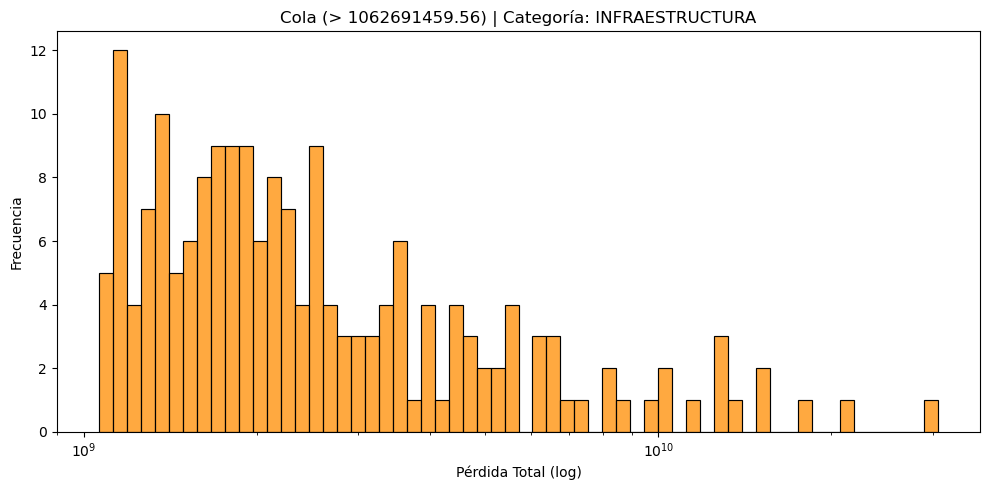

Tamaño cuerpo: 821 | Tamaño cola: 186 | Proporción cola: 0.185

 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.00

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.11

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.40

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.20

Resumen métricas cuerpo:
      modelo           WAIC            DIC          KS_p            AD  \
1    Weibull   33416.074310   33416.069784  5.365318e-15     38.260225   
2  Lognormal   33536.171509   33536.102331  3.931687e-06     14.023520   
3       Fisk   33519.707407   33519.699846  8.602484e-09     15.418077   
0      Gamma  138118.718917  138118.718917  0.000000e+00  10079.406426   

   rank_mediana  
1           2.0  
2           2.0  
3           2.0  
0           4.0  

Modelo seleccionado para el cuerpo: Lognormal


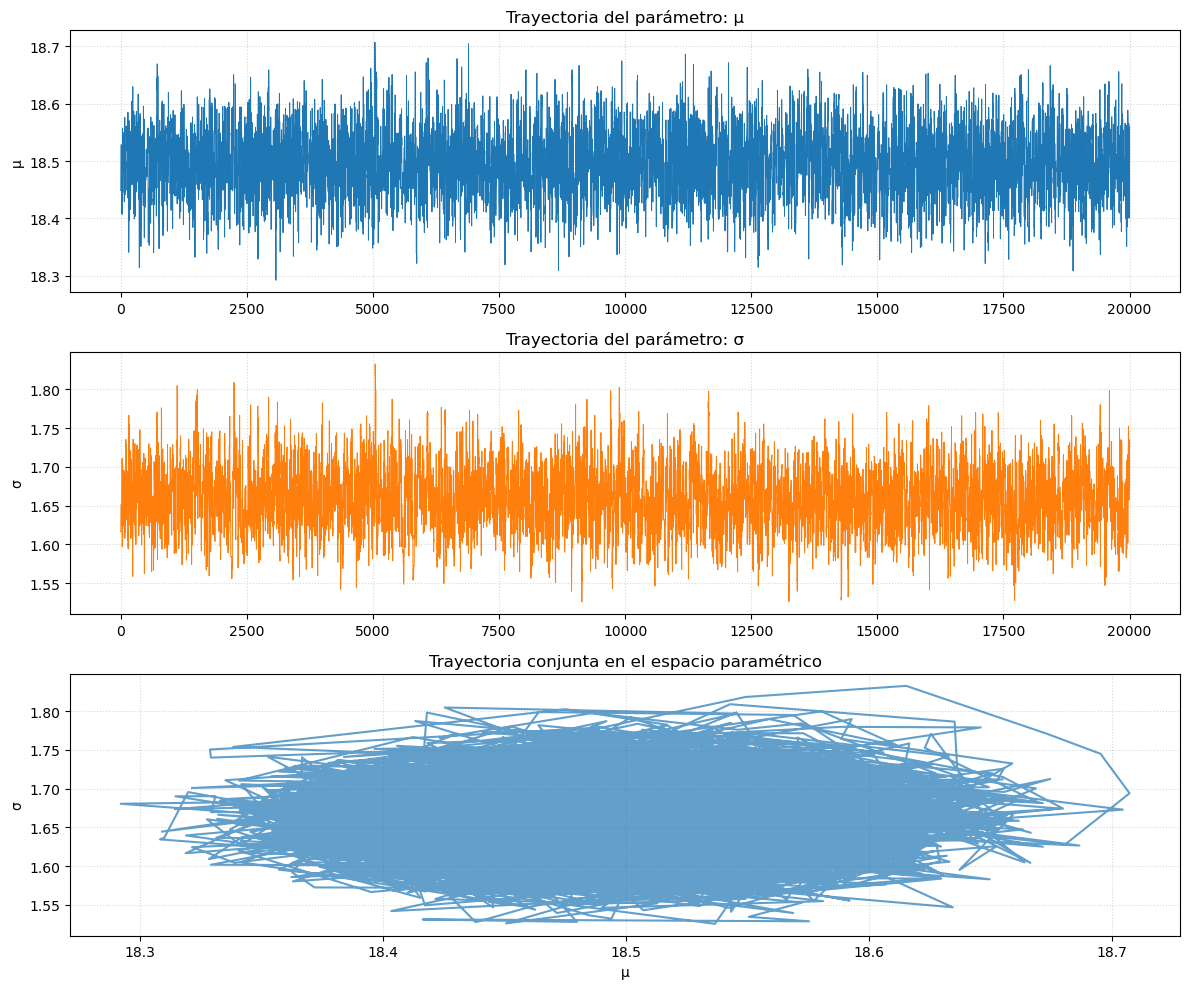


 Ajustando cola: GPD
Tasa aceptación GPD: 0.47

 Ajustando cola: Burr
Tasa aceptación Burr: 0.21

 Ajustando cola: Pareto
Tasa aceptación Pareto: 0.44

 Ajustando cola: LN_tail
Tasa aceptación LN_tail: 0.85

Resumen métricas cola:
    modelo         WAIC      KS_p         AD  rank_mediana
1     Burr  8373.844093  0.840249   0.361199           1.0
3  LN_tail  8377.678065  0.064411   2.141070           2.0
2   Pareto  8381.244819  0.033379   2.695513           3.0
0      GPD  8391.664597  0.000001  10.860669           4.0

Modelo seleccionado para la cola: Burr


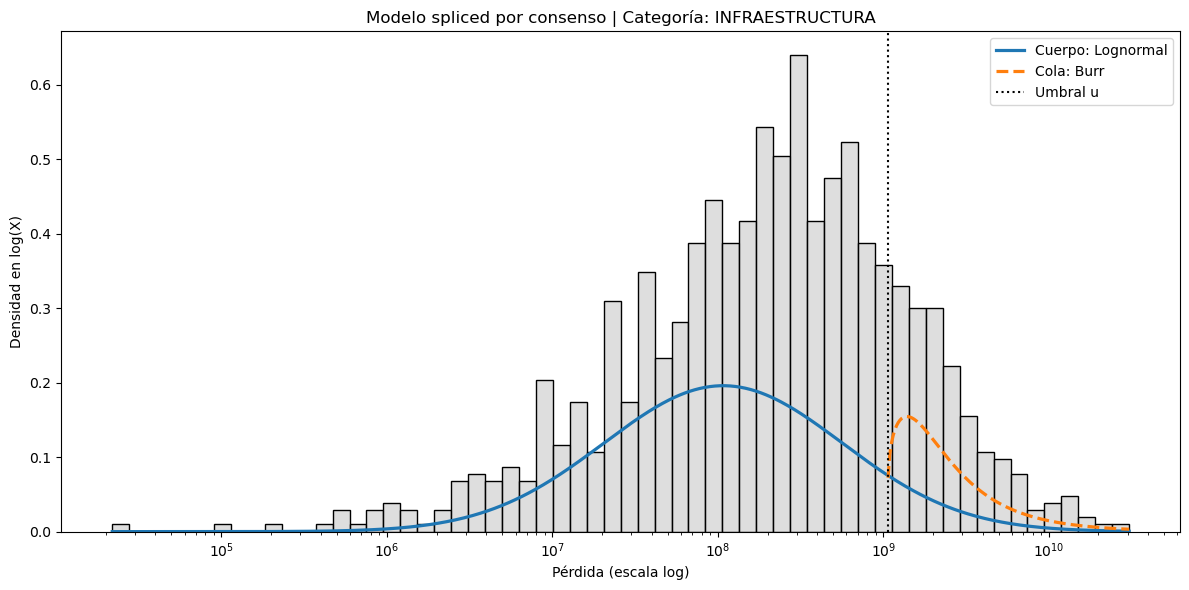

Análisis por consenso para la categoría SOCIAL
La proporción de datos para  SOCIAL es  0.065


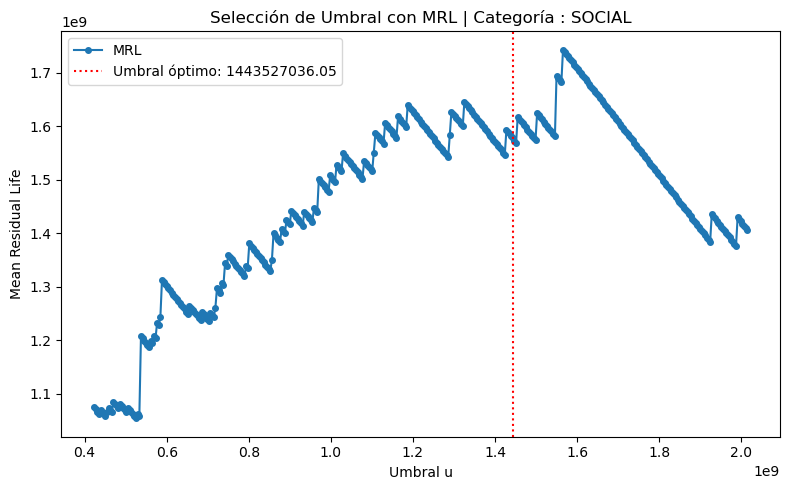

Umbral óptimo: 1,443,527,036.05


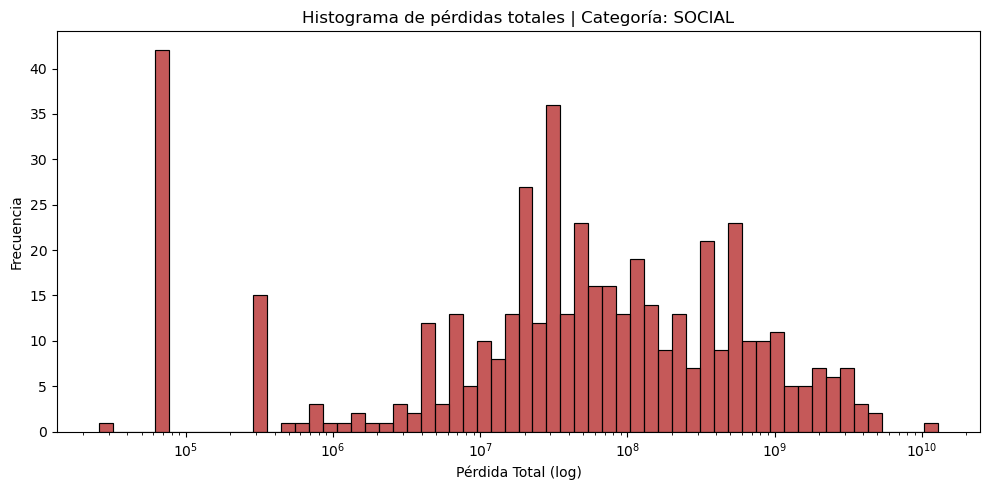

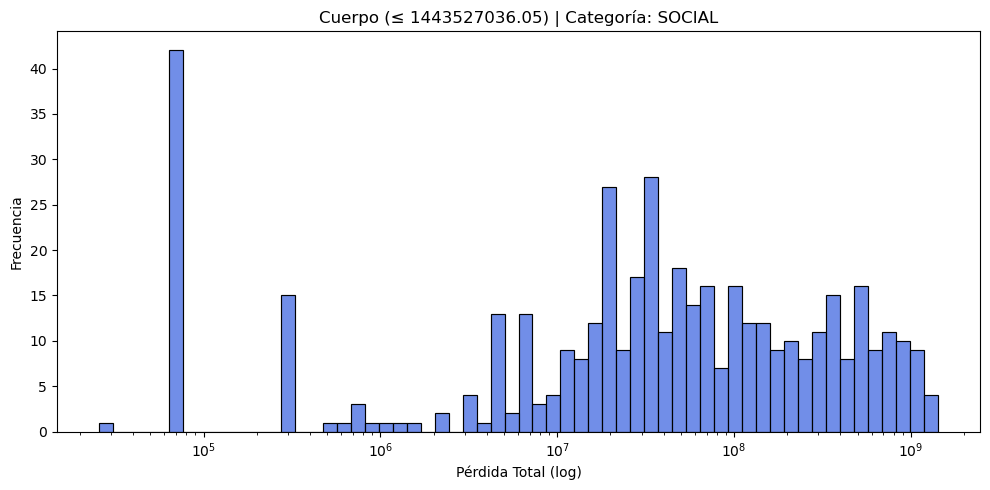

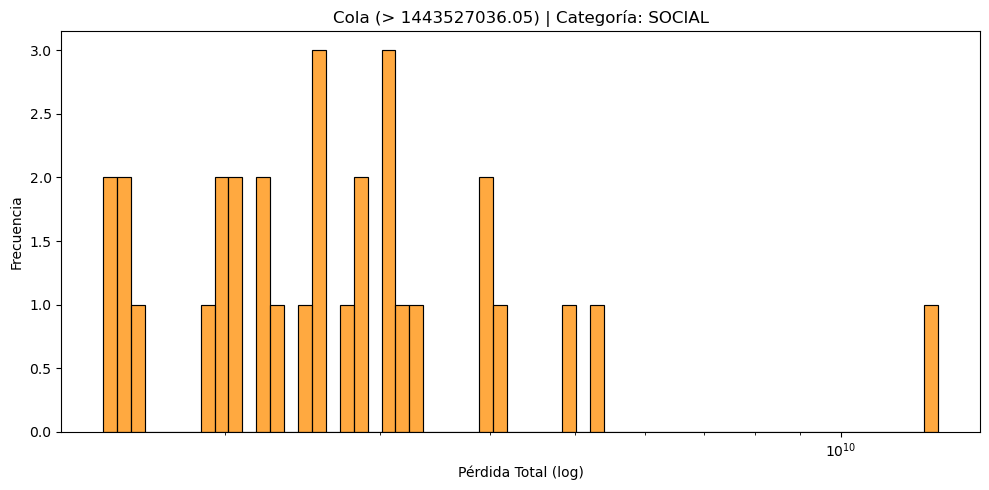

Tamaño cuerpo: 445 | Tamaño cola: 31 | Proporción cola: 0.065

 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.00

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.09

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.69

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.17

Resumen métricas cuerpo:
      modelo          WAIC           DIC          KS_p           AD  \
3       Fisk  1.737385e+04  1.737384e+04  6.654559e-04     9.355320   
1    Weibull  1.734586e+04  1.734585e+04  1.271513e-16    33.019687   
2  Lognormal  1.738430e+04  1.738427e+04  1.686916e-07    13.650067   
0      Gamma  2.231283e+06  2.231283e+06  0.000000e+00  8743.399396   

   rank_mediana  
3           1.5  
1           2.0  
2           2.5  
0           4.0  

Modelo seleccionado para el cuerpo: Fisk


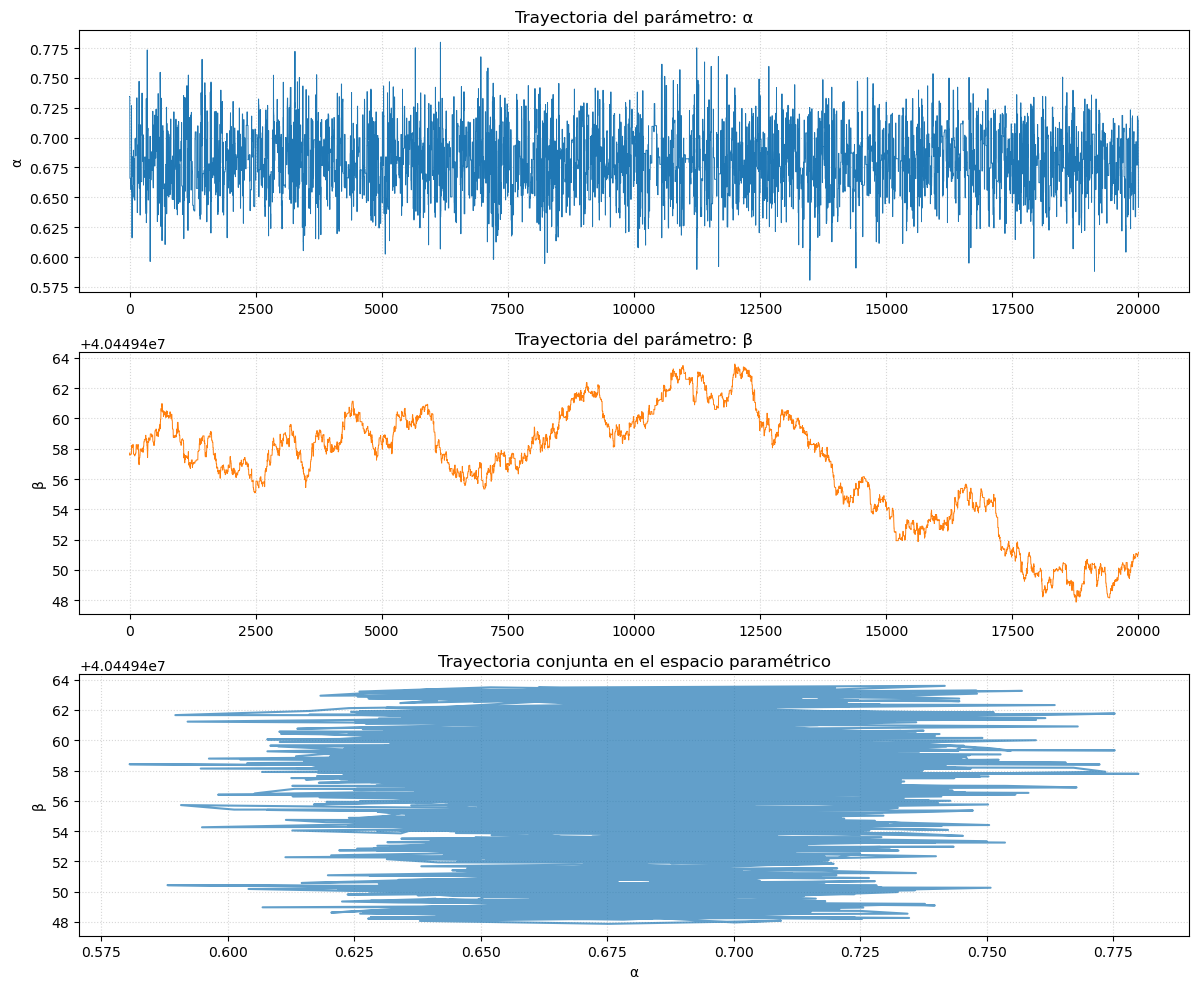


 Ajustando cola: GPD
Tasa aceptación GPD: 0.65

 Ajustando cola: Burr
Tasa aceptación Burr: 0.58

 Ajustando cola: Pareto
Tasa aceptación Pareto: 0.75

 Ajustando cola: LN_tail
Tasa aceptación LN_tail: 0.91

Resumen métricas cola:
    modelo         WAIC      KS_p        AD  rank_mediana
0      GPD  1376.990197  0.370063  0.870025           1.0
1     Burr  1380.779101  0.470945  0.946073           2.0
3  LN_tail  1378.289066  0.098978  1.385138           3.0
2   Pareto  1380.661349  0.049430  1.764650           4.0

Modelo seleccionado para la cola: GPD


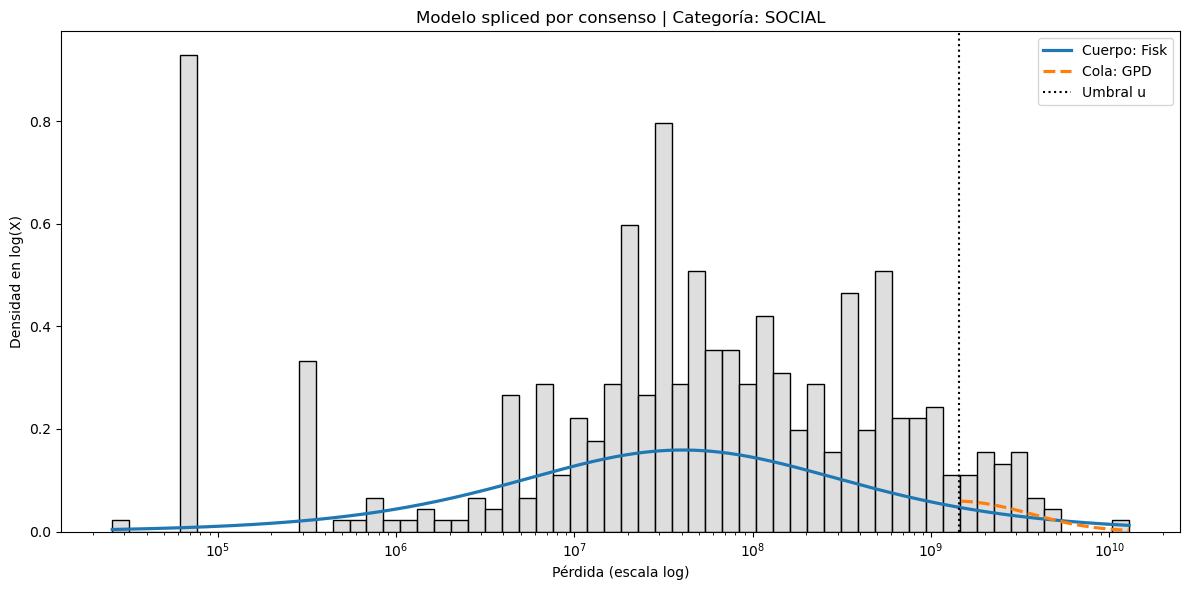

Análisis por consenso para la categoría OTROS
La proporción de datos para  OTROS es  0.058


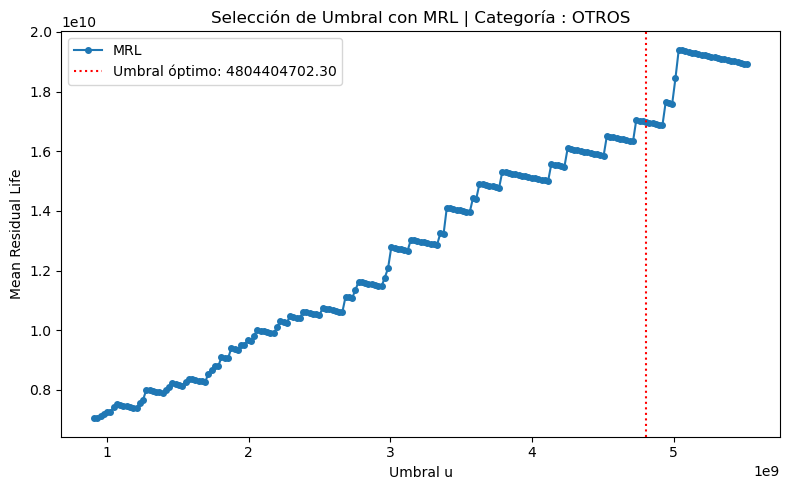

Umbral óptimo: 4,804,404,702.30


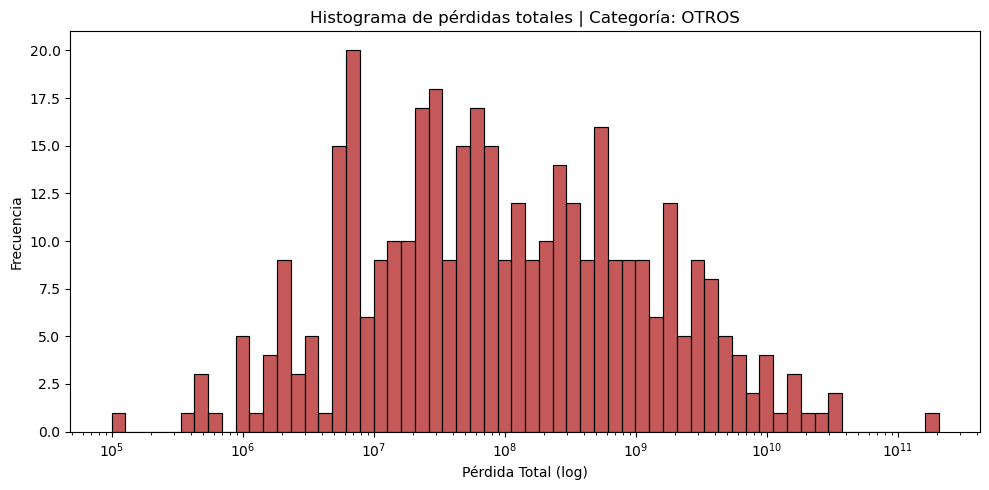

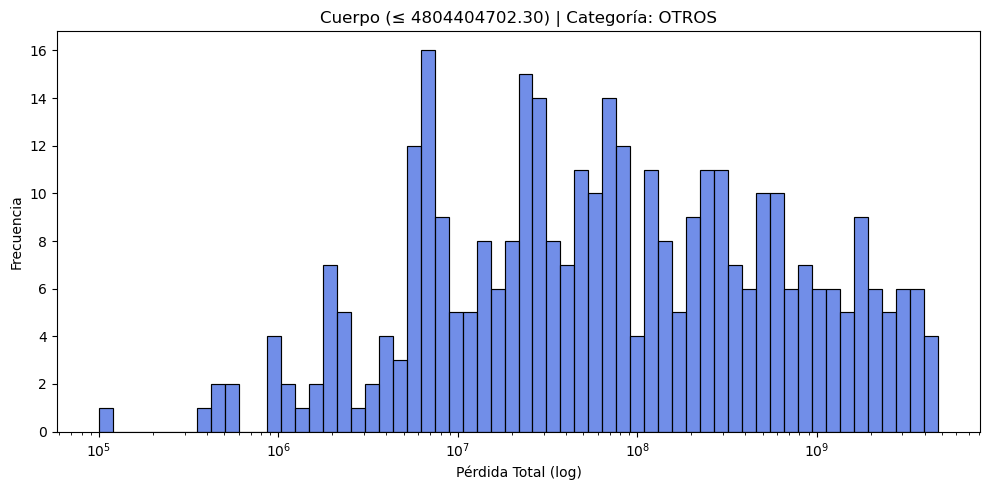

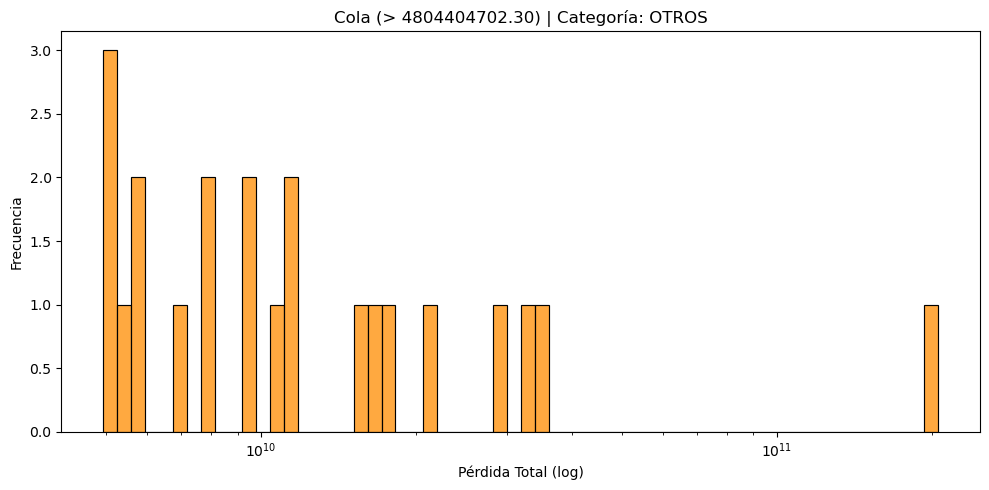

Tamaño cuerpo: 355 | Tamaño cola: 22 | Proporción cola: 0.058

 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.00

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.09

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.66

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.21

Resumen métricas cuerpo:
      modelo          WAIC           DIC          KS_p           AD  \
2  Lognormal  1.442770e+04  1.442768e+04  4.411217e-01     1.207066   
3       Fisk  1.444690e+04  1.444689e+04  9.535112e-02     2.081121   
1    Weibull  1.453407e+04  1.453404e+04  1.412708e-13    39.765267   
0      Gamma  1.114474e+07  1.114474e+07  0.000000e+00  9271.409349   

   rank_mediana  
2           1.0  
3           2.0  
1           3.0  
0           4.0  

Modelo seleccionado para el cuerpo: Lognormal


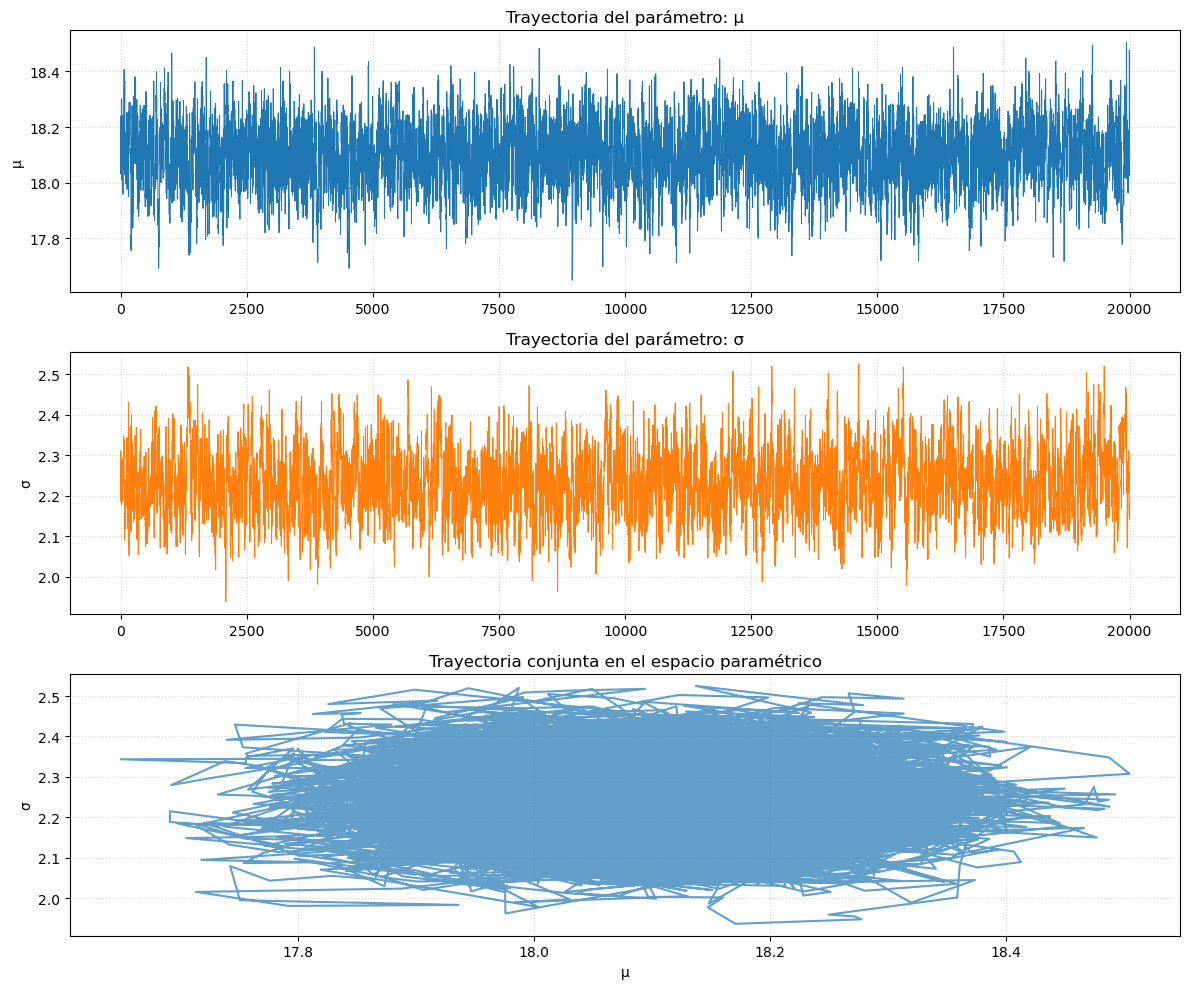


 Ajustando cola: GPD
Tasa aceptación GPD: 0.76

 Ajustando cola: Burr
Tasa aceptación Burr: 0.55

 Ajustando cola: Pareto
Tasa aceptación Pareto: 0.75

 Ajustando cola: LN_tail
Tasa aceptación LN_tail: 0.96

Resumen métricas cola:
    modelo         WAIC      KS_p        AD  rank_mediana
3  LN_tail  1064.296638  0.979529  0.265123           1.0
2   Pareto  1064.419015  0.960438  0.297710           2.0
1     Burr  1066.466533  0.921597  0.303009           3.0
0      GPD  1075.116339  0.012011  5.536118           4.0

Modelo seleccionado para la cola: LN_tail


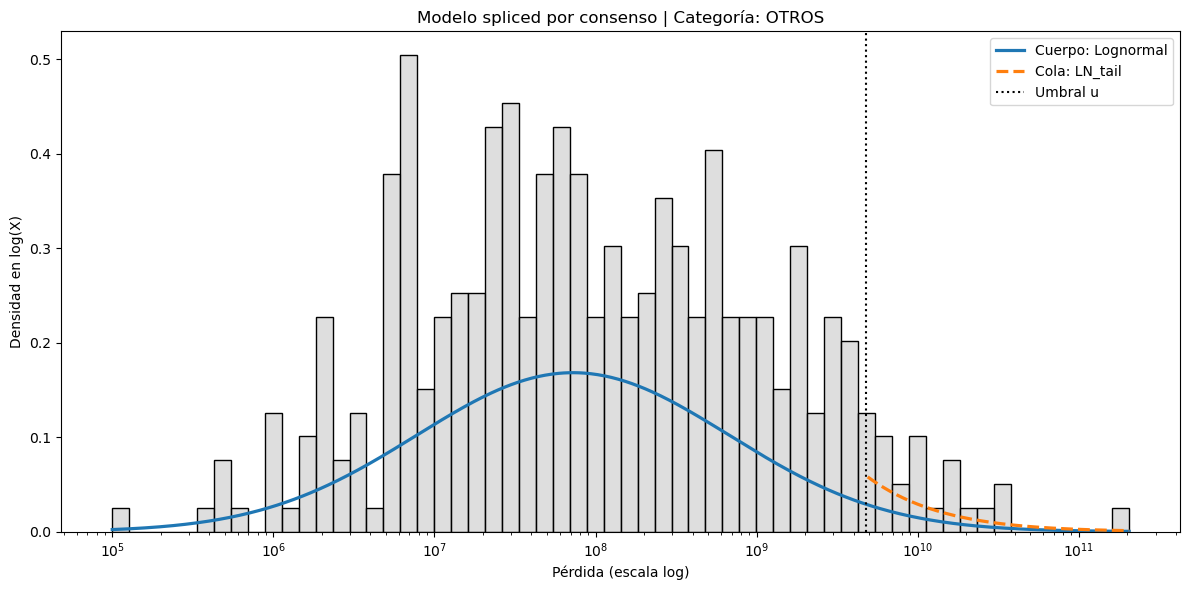

Análisis por consenso para la categoría HÍDRICO
La proporción de datos para  HÍDRICO es  0.095


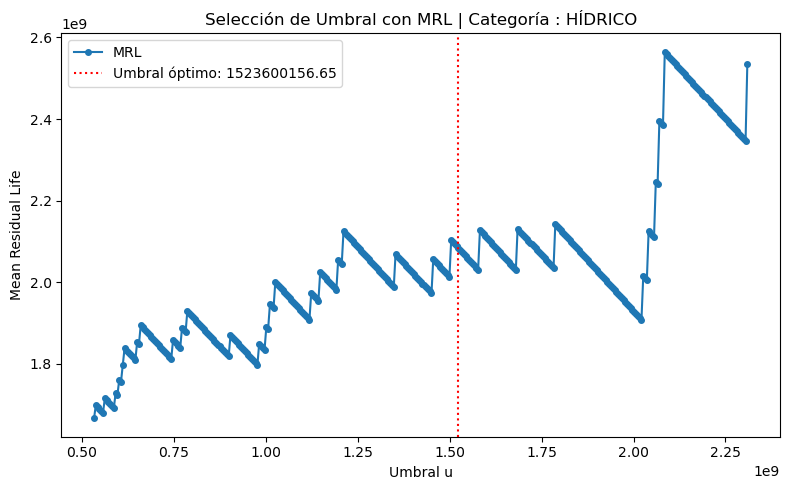

Umbral óptimo: 1,523,600,156.65


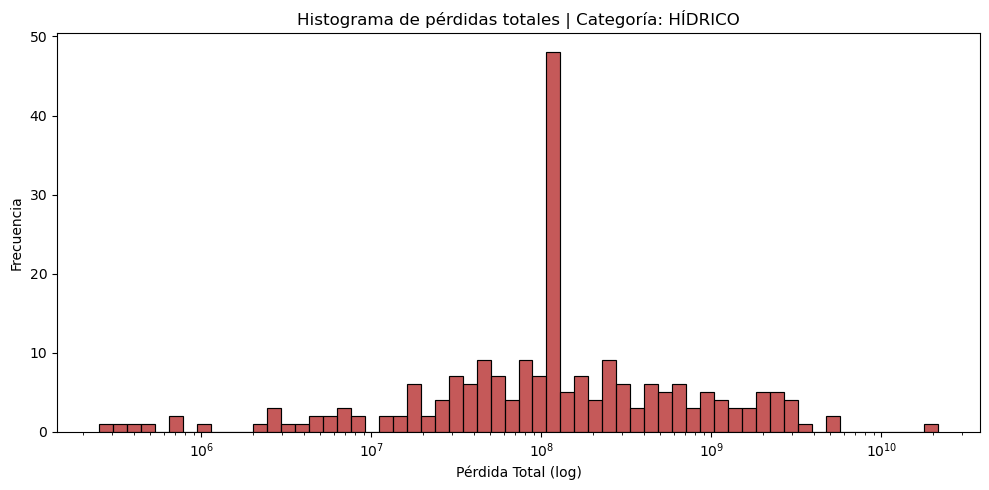

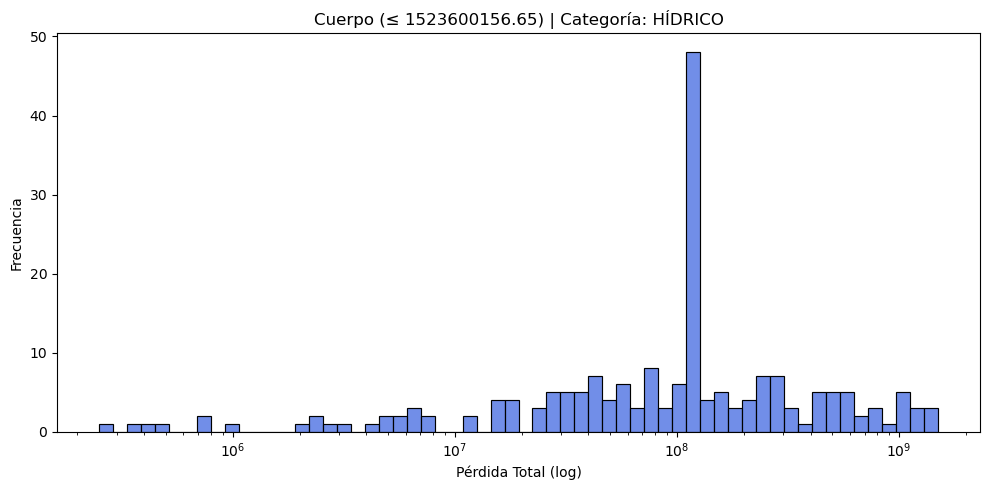

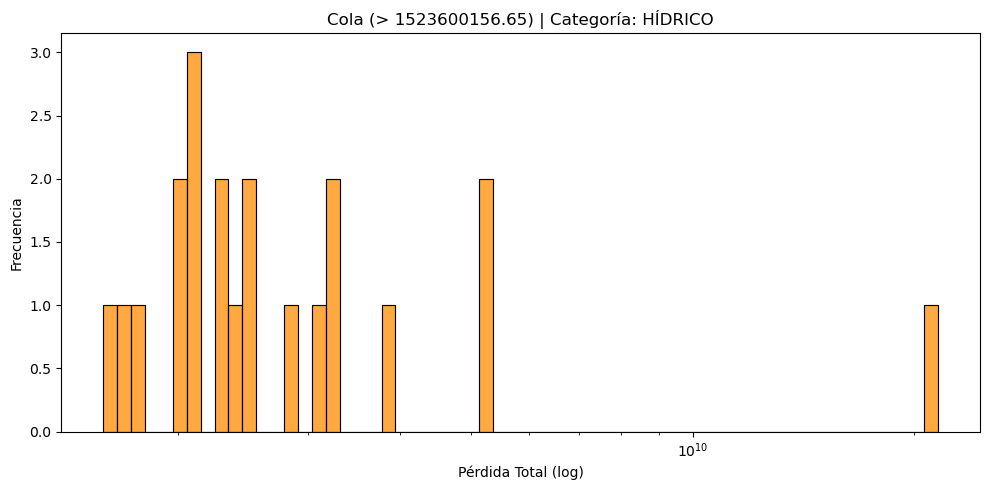

Tamaño cuerpo: 201 | Tamaño cola: 21 | Proporción cola: 0.095

 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.00

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.20

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.66

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.38

Resumen métricas cuerpo:
      modelo          WAIC           DIC           KS_p           AD  \
1    Weibull   8085.203985   8085.161921   8.212824e-07     9.141856   
2  Lognormal   8104.724968   8104.567469   3.999801e-04     4.843222   
3       Fisk   8091.406976   8091.381766   7.603660e-05     4.991865   
0      Gamma  72263.107188  72263.107188  1.062772e-227  4027.176031   

   rank_mediana  
1           2.0  
2           2.0  
3           2.0  
0           4.0  

Modelo seleccionado para el cuerpo: Lognormal


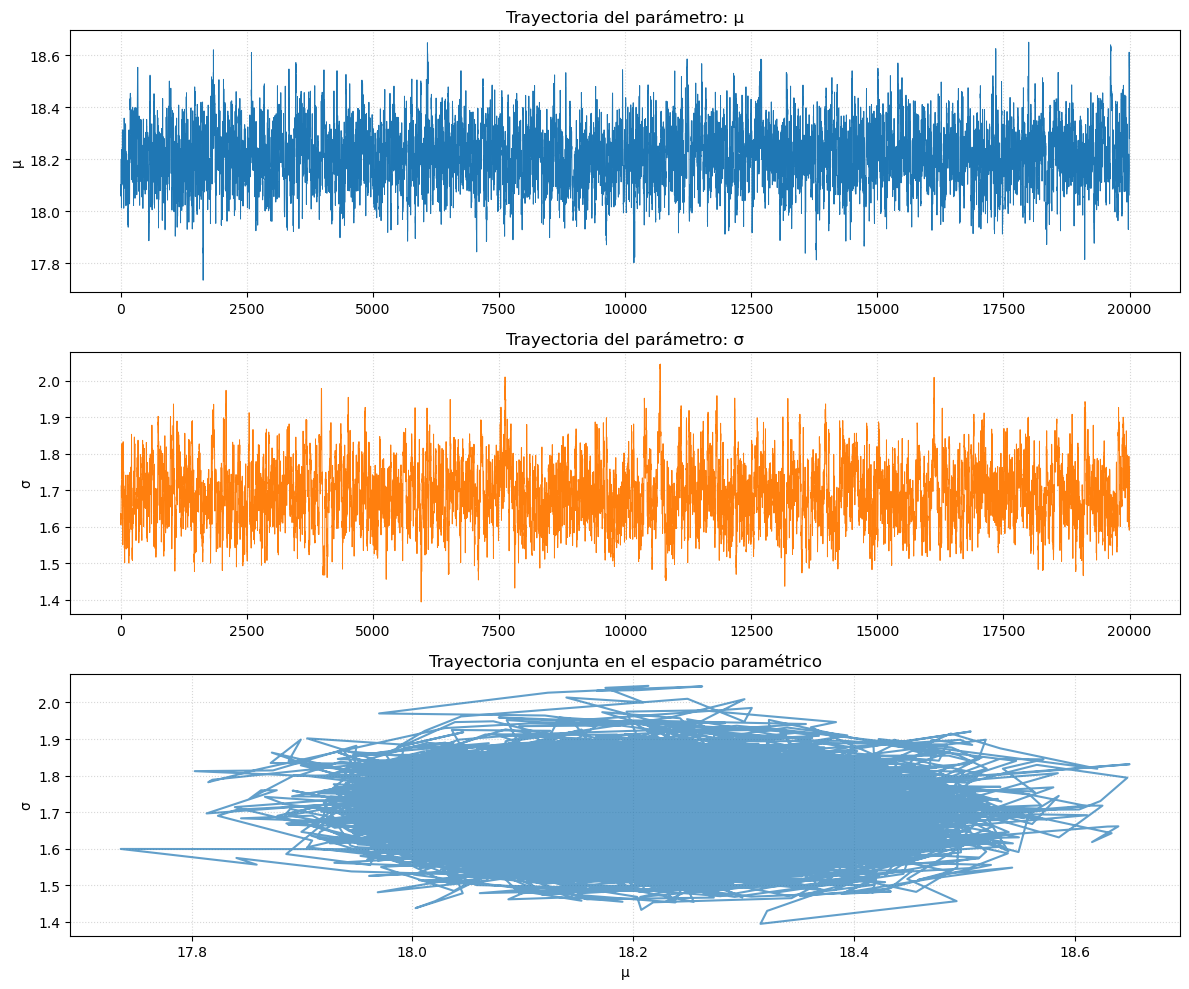


 Ajustando cola: GPD
Tasa aceptación GPD: 0.73

 Ajustando cola: Burr
Tasa aceptación Burr: 0.61

 Ajustando cola: Pareto
Tasa aceptación Pareto: 0.75

 Ajustando cola: LN_tail
Tasa aceptación LN_tail: 0.51

Resumen métricas cola:
    modelo        WAIC      KS_p        AD  rank_mediana
1     Burr  937.359665  0.809233  0.246827           1.0
2   Pareto  939.341509  0.064218  1.281385           2.0
3  LN_tail  927.653315  0.034343  2.758585           3.0
0      GPD  941.322113  0.033495  2.380154           4.0

Modelo seleccionado para la cola: Burr


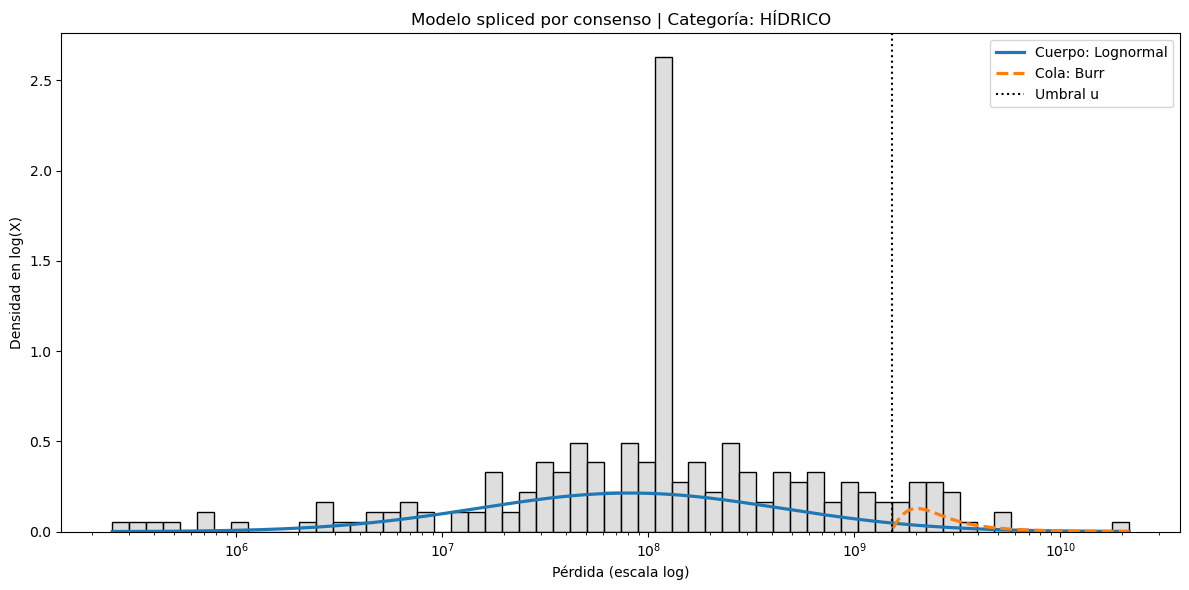

Análisis por consenso para la categoría PRODUCTIVO
La proporción de datos para  PRODUCTIVO es  0.056


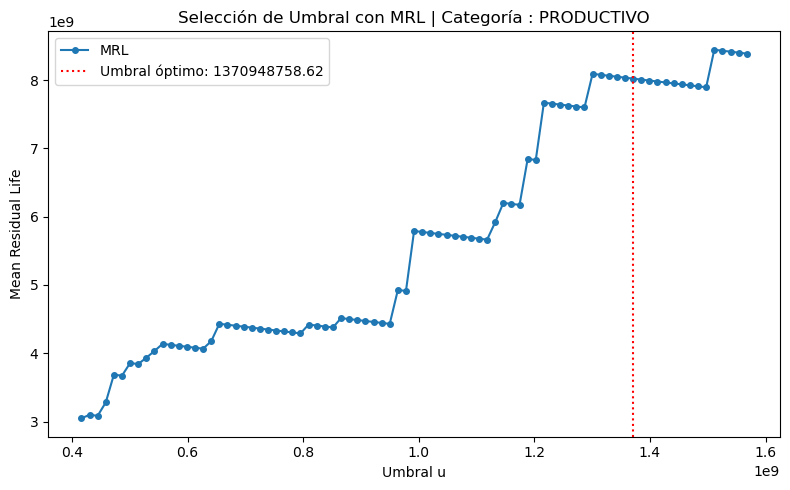

Umbral óptimo: 1,370,948,758.62


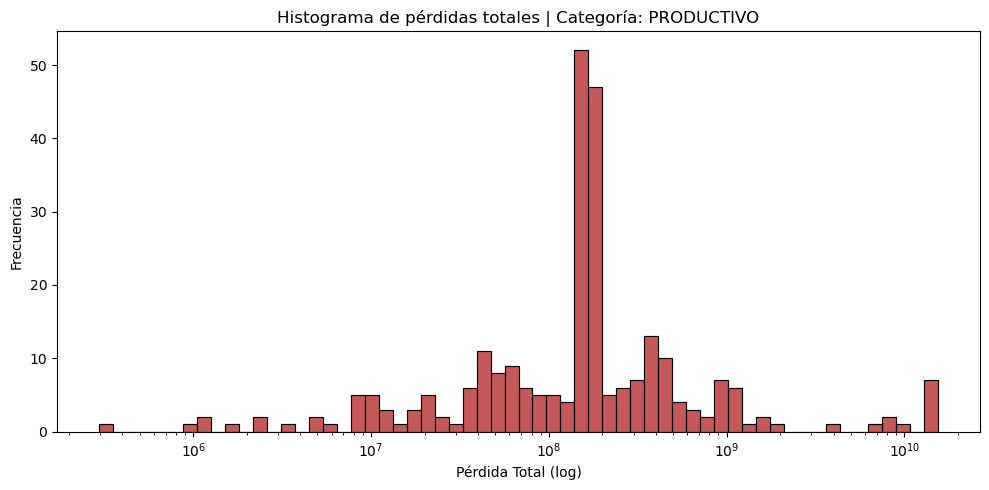

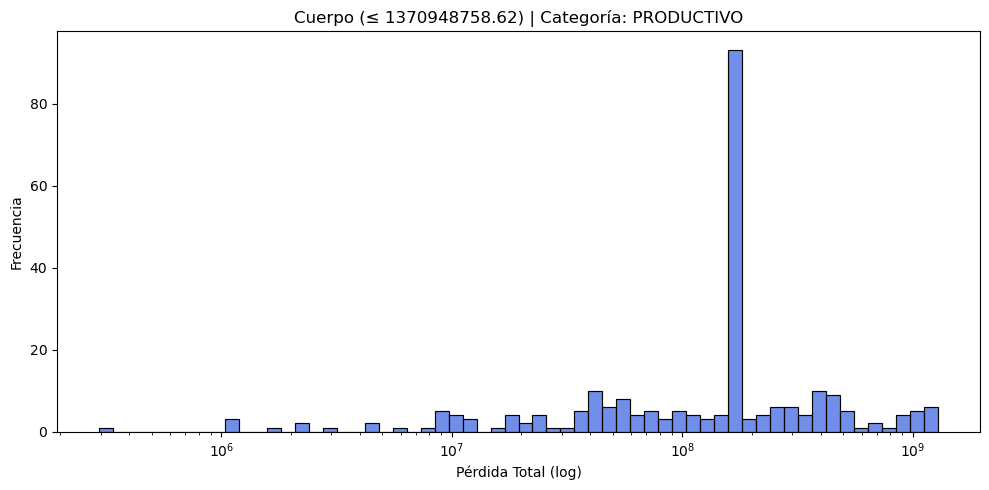

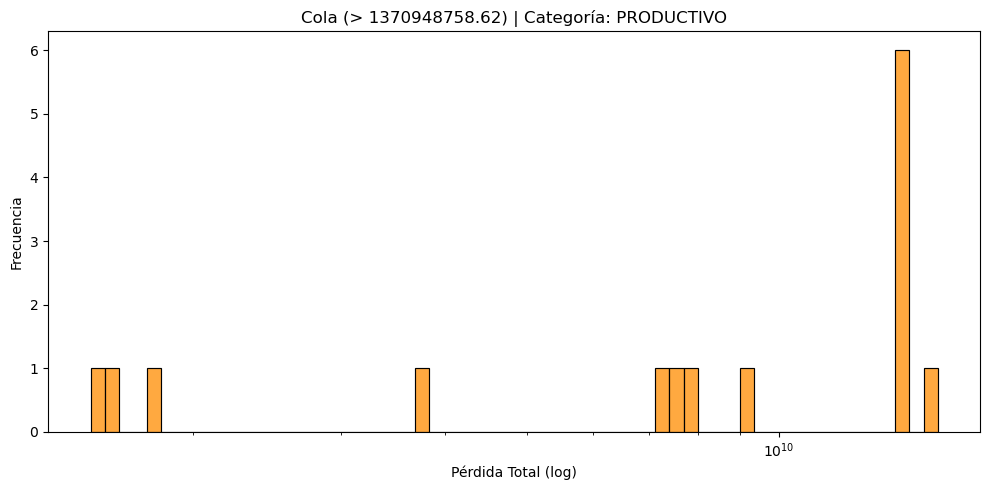

Tamaño cuerpo: 253 | Tamaño cola: 15 | Proporción cola: 0.056

 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.00

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.22

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.57

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.41

Resumen métricas cuerpo:
      modelo          WAIC           DIC          KS_p           AD  \
1    Weibull  1.023763e+04  1.023758e+04  7.355088e-15    11.811119   
3       Fisk  1.025929e+04  1.025926e+04  3.815900e-10    11.362055   
2  Lognormal  1.027743e+04  1.027723e+04  9.070874e-12     9.713937   
0      Gamma  1.094283e+06  1.094283e+06  0.000000e+00  6564.917946   

   rank_mediana  
1           2.0  
3           2.0  
2           2.5  
0           4.0  

Modelo seleccionado para el cuerpo: Lognormal


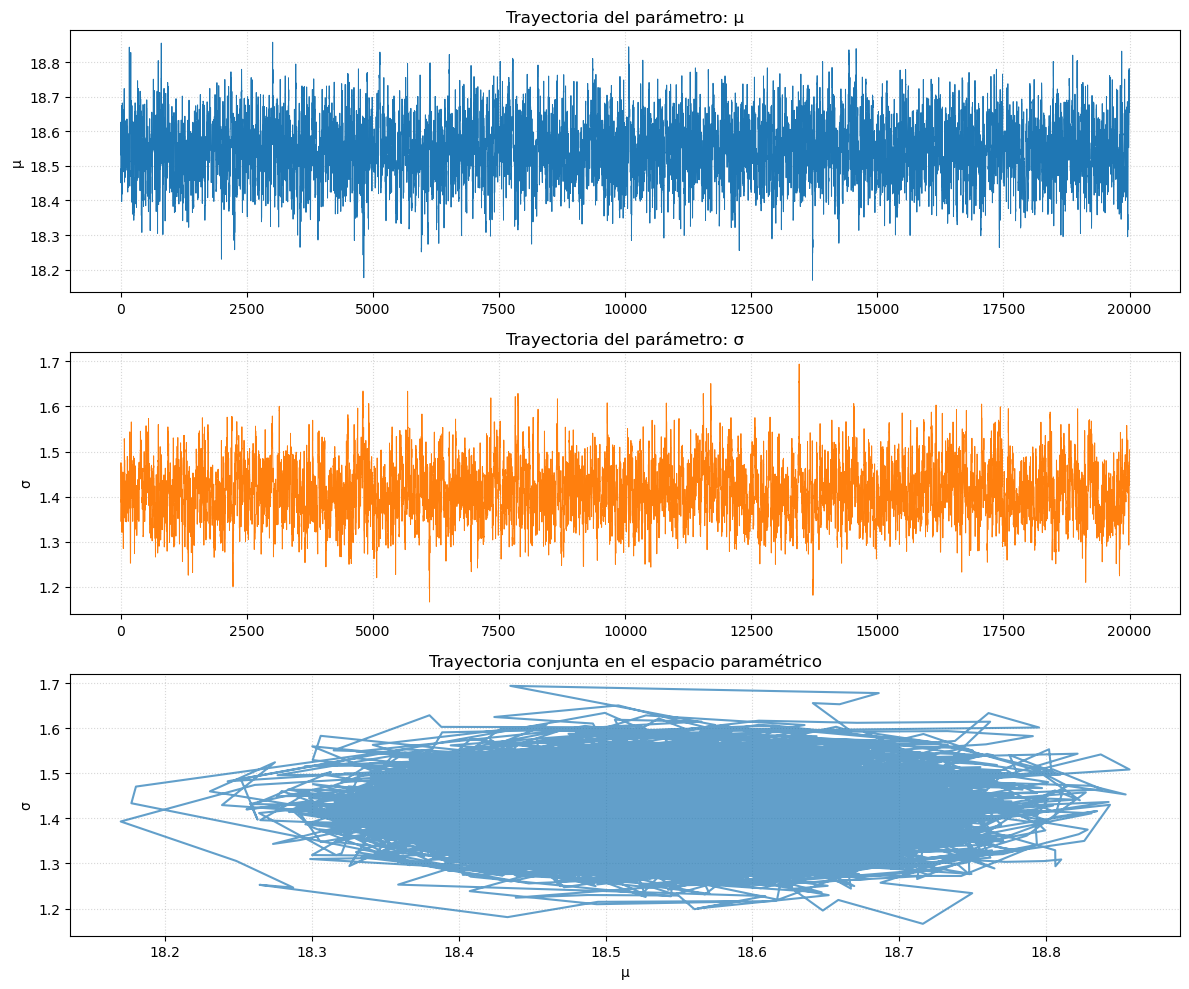


 Ajustando cola: GPD
Tasa aceptación GPD: 0.70

 Ajustando cola: Burr
Tasa aceptación Burr: 0.69

 Ajustando cola: Pareto
Tasa aceptación Pareto: 0.84

 Ajustando cola: LN_tail
Tasa aceptación LN_tail: 0.96

Resumen métricas cola:
    modelo        WAIC      KS_p        AD  rank_mediana
0      GPD  713.077106  0.070250  2.090115           2.0
1     Burr  723.884273  0.100046  2.012549           2.0
2   Pareto  720.854753  0.058605  1.915412           2.0
3  LN_tail  724.785287  0.016490  2.352213           4.0

Modelo seleccionado para la cola: GPD


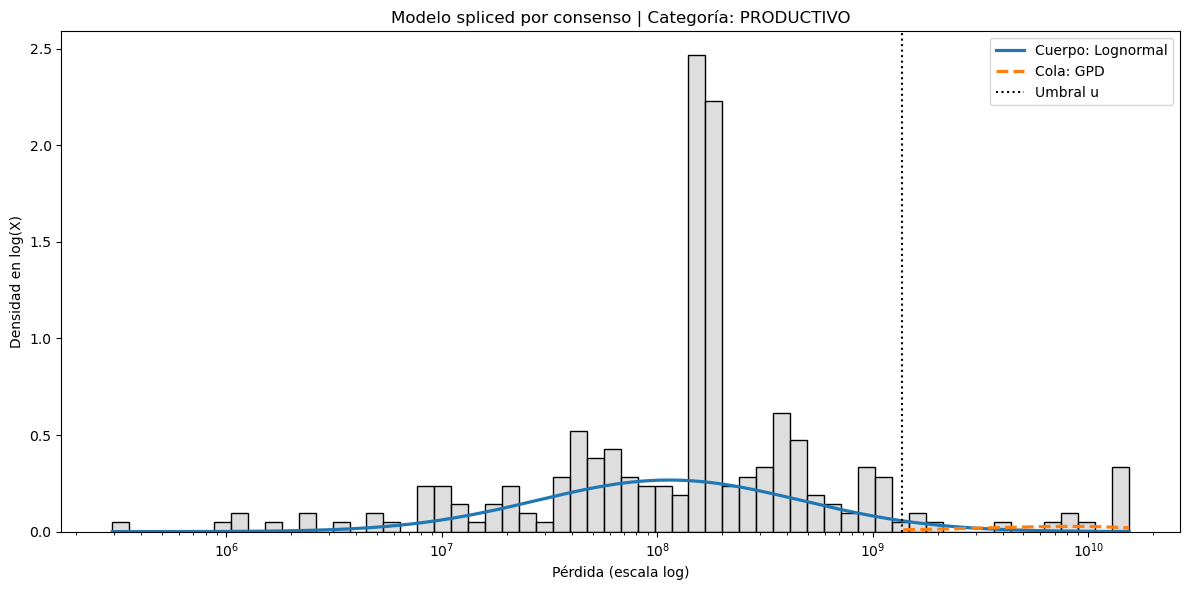

In [45]:
resultados_categoria = {}
for name in df['categoria'].unique():
    res = pipeline_categoria_consenso(df, categoria=name,
                                     n_iter=50000, burn=30000)
    resultados_categoria[name] = res
    guardar_resultados_csv(name, res, carpeta="../res/csv_categoria")

Análisis por consenso para la provincia Cartago
La proporción de datos para  Cartago es  0.118


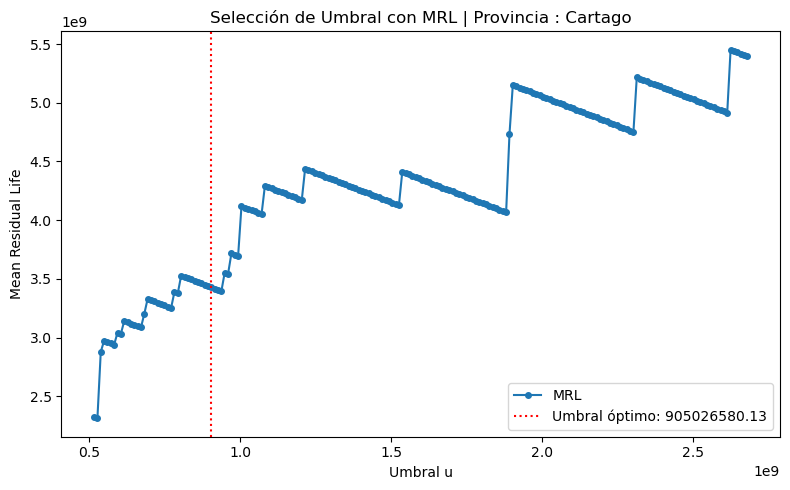

Umbral óptimo: 905,026,580.13


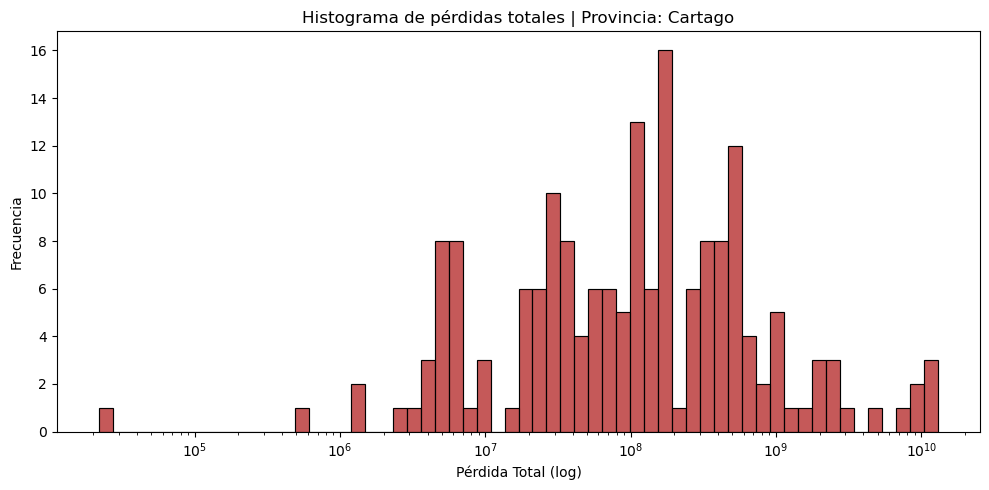

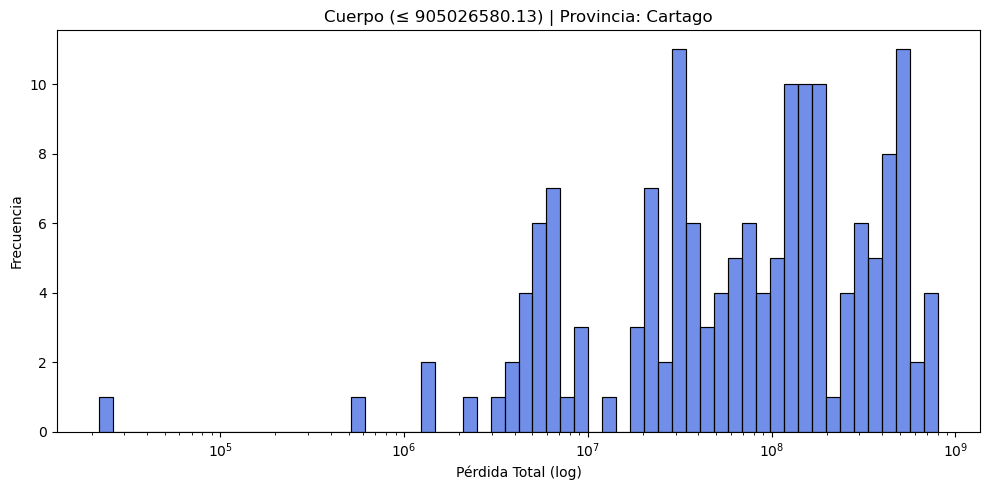

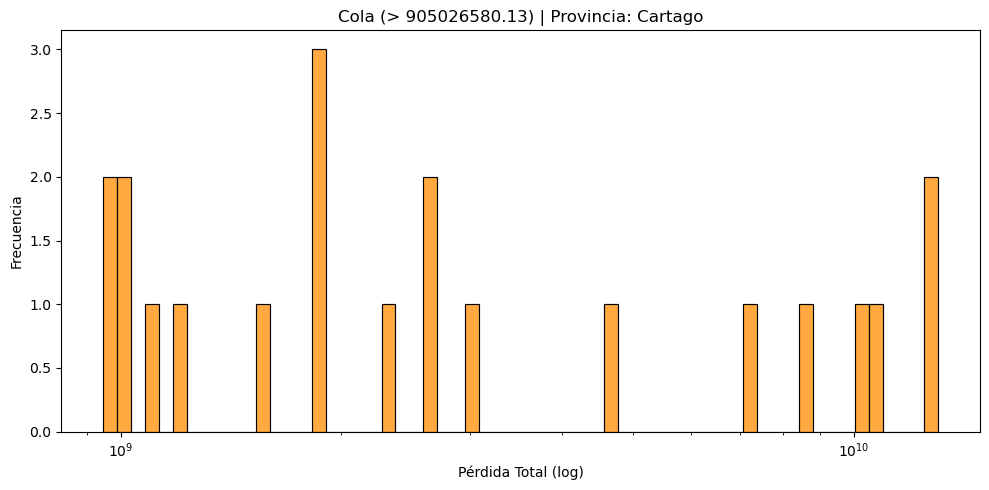

Tamaño cuerpo: 157 | Tamaño cola: 21 | Proporción cola: 0.118

 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.00

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.23

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.71

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.38

Resumen métricas cuerpo:
      modelo          WAIC            DIC           KS_p           AD  \
1    Weibull  6.243079e+03    6243.063276   1.566418e-03     6.908097   
2  Lognormal  6.260897e+03    6260.630785   9.005694e-02     2.228968   
3       Fisk  6.258791e+03    6258.763291   8.514589e-02     3.417316   
0      Gamma  1.389905e+08  442255.448217  9.162497e-250  3677.887540   

   rank_mediana  
1           2.0  
2           2.0  
3           2.0  
0           4.0  

Modelo seleccionado para el cuerpo: Lognormal


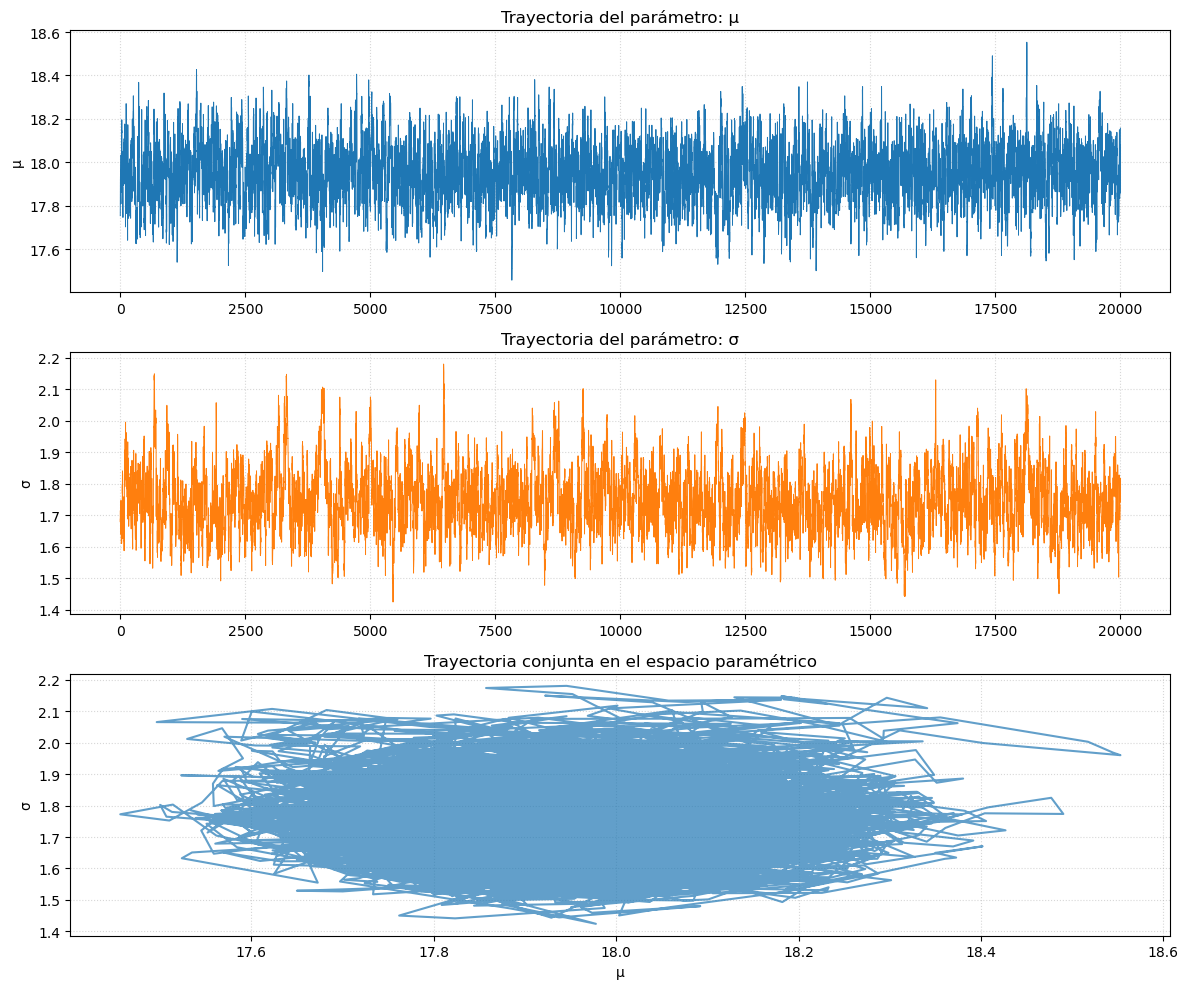


 Ajustando cola: GPD
Tasa aceptación GPD: 0.76

 Ajustando cola: Burr
Tasa aceptación Burr: 0.54

 Ajustando cola: Pareto
Tasa aceptación Pareto: 0.75

 Ajustando cola: LN_tail
Tasa aceptación LN_tail: 0.97

Resumen métricas cola:
    modelo        WAIC      KS_p        AD  rank_mediana
1     Burr  964.539872  0.770585  0.566978           1.0
2   Pareto  962.995657  0.740141  0.643911           2.0
3  LN_tail  962.827068  0.722015  0.586997           2.0
0      GPD  964.971444  0.147504  2.583930           4.0

Modelo seleccionado para la cola: Burr


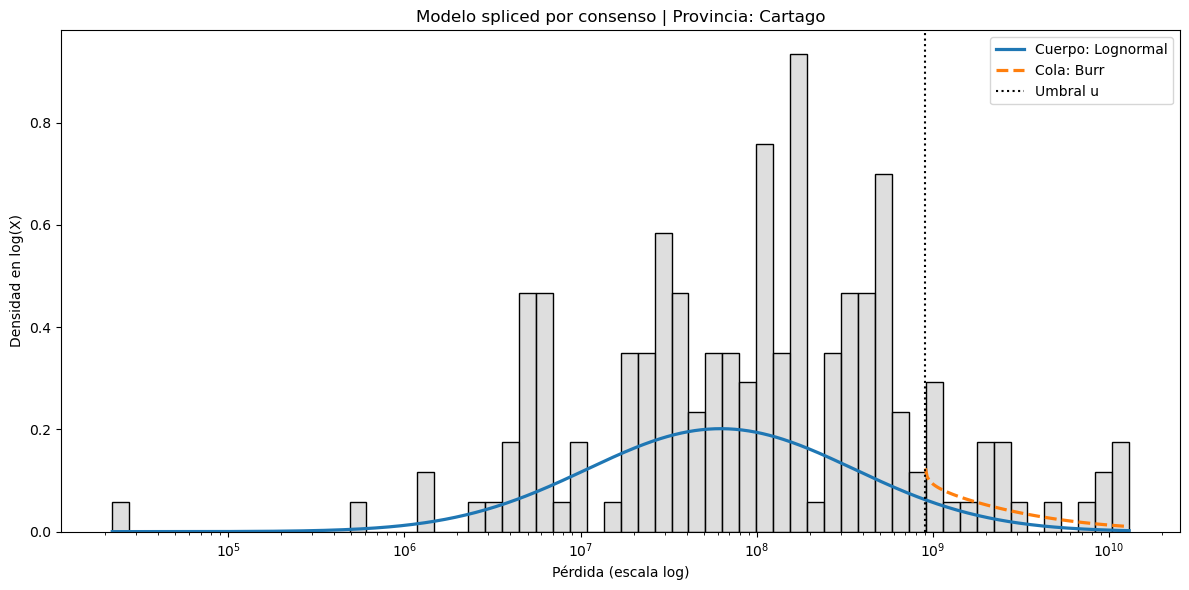

Análisis por consenso para la provincia Heredia
La proporción de datos para  Heredia es  0.081


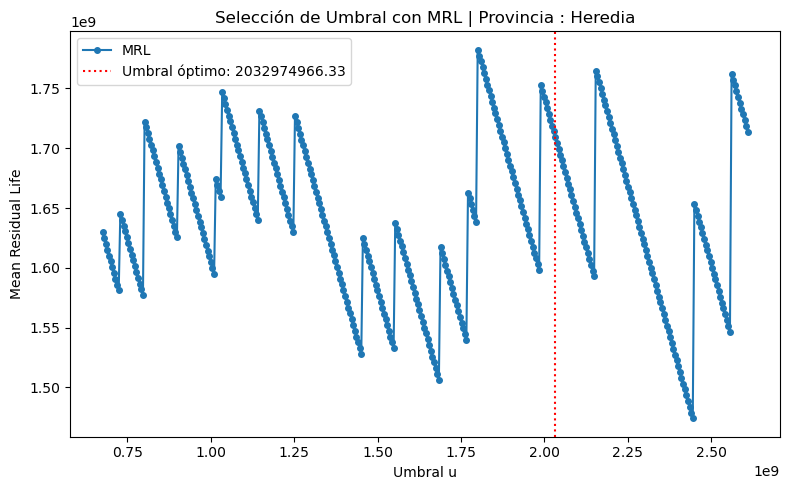

Umbral óptimo: 2,032,974,966.33


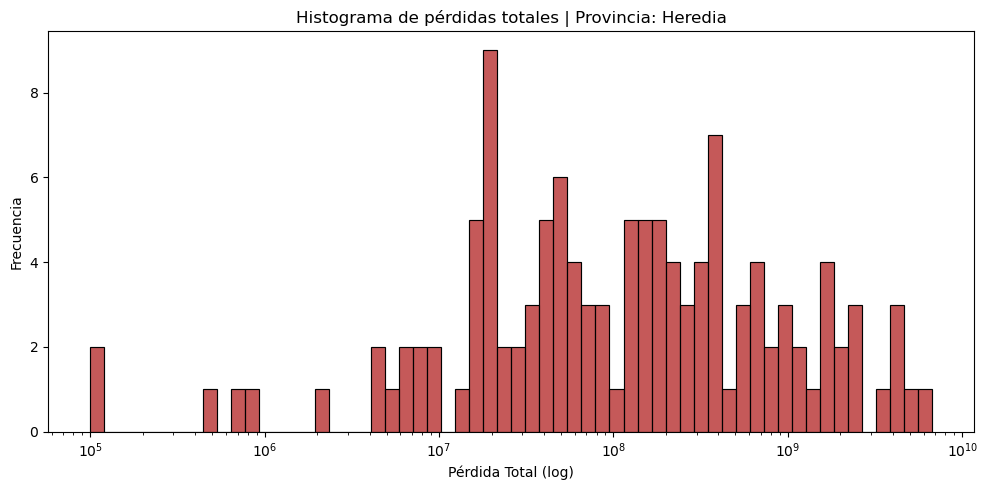

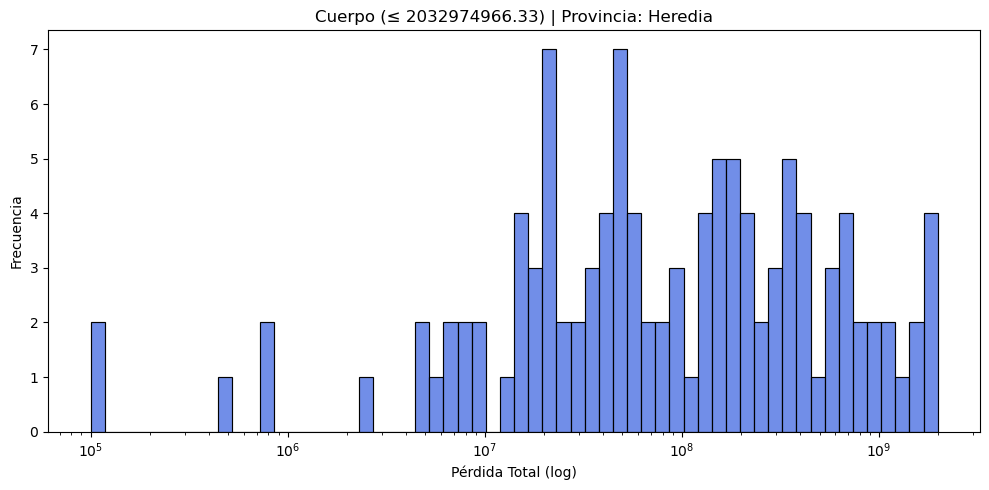

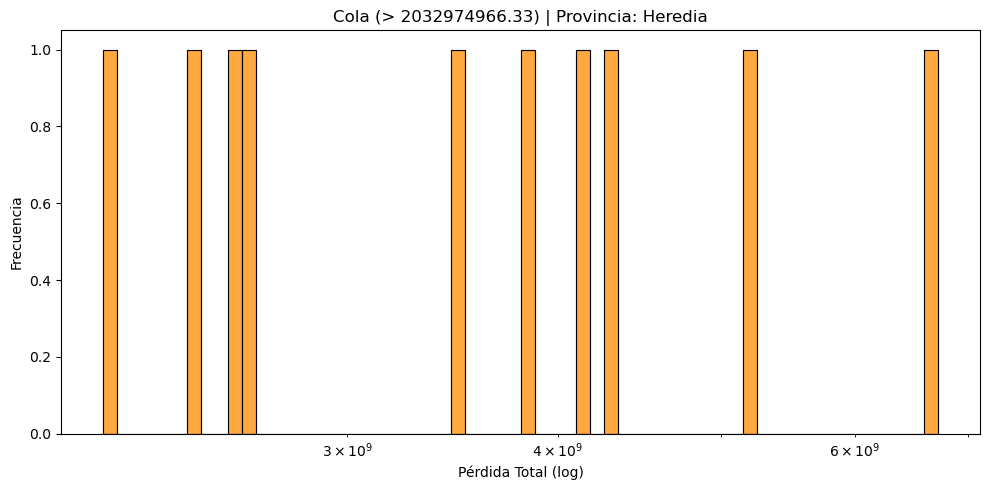

Tamaño cuerpo: 113 | Tamaño cola: 10 | Proporción cola: 0.081

 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.00

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.20

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.78

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.39

Resumen métricas cuerpo:
      modelo           WAIC            DIC           KS_p           AD  \
3       Fisk    4578.933780    4578.903979   7.346260e-01     0.630045   
2  Lognormal    4584.153415    4583.877220   5.519028e-01     0.917163   
1    Weibull    4590.228923    4590.187017   4.098969e-04     9.795307   
0      Gamma  258628.041084  258628.041084  6.860323e-153  2645.095565   

   rank_mediana  
3           1.0  
2           2.0  
1           3.0  
0           4.0  

Modelo seleccionado para el cuerpo: Fisk


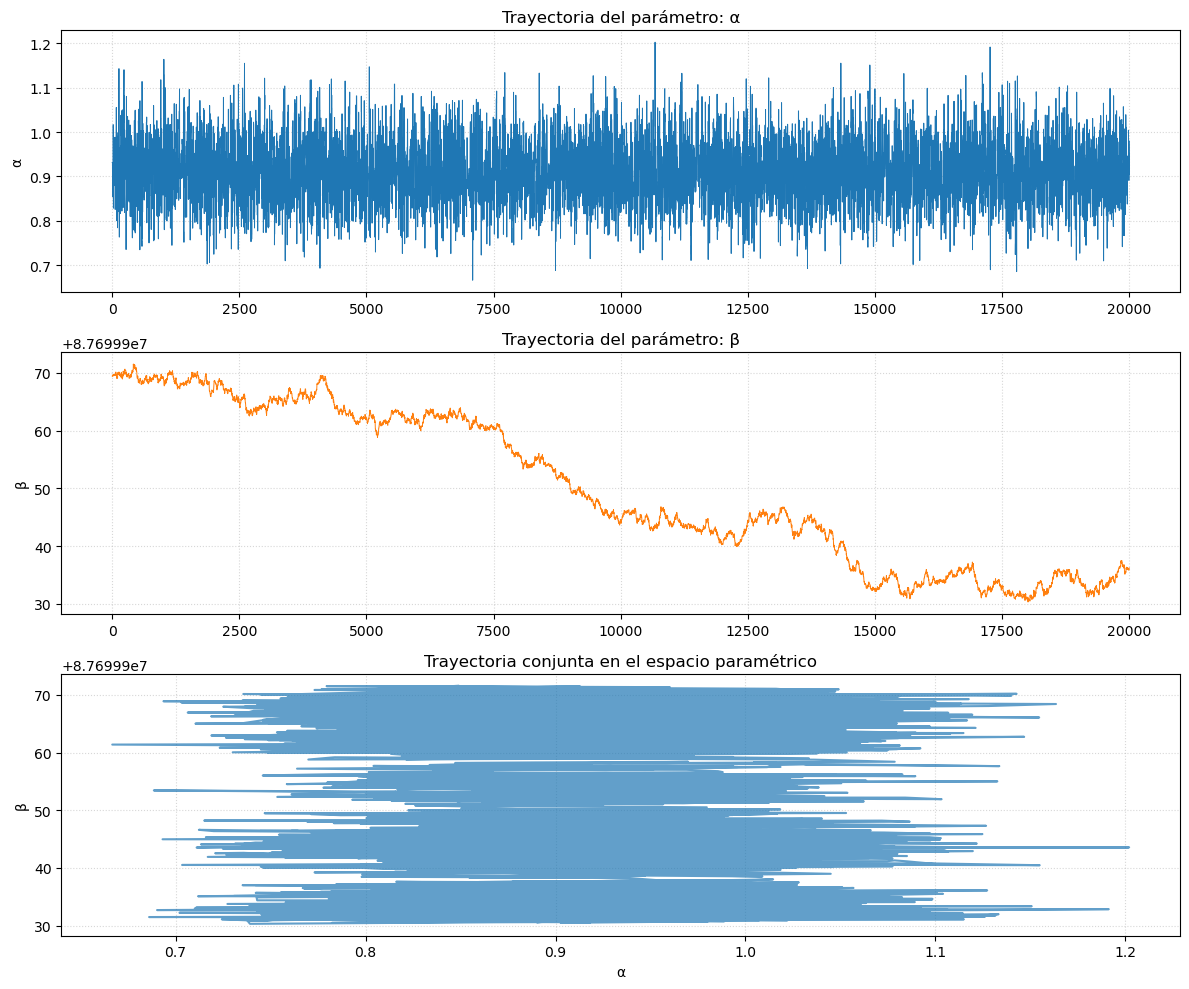


 Ajustando cola: GPD
Tasa aceptación GPD: 0.75

 Ajustando cola: Burr
Tasa aceptación Burr: 0.76

 Ajustando cola: Pareto
Tasa aceptación Pareto: 0.87

 Ajustando cola: LN_tail
Tasa aceptación LN_tail: 0.93

Resumen métricas cola:
    modelo        WAIC      KS_p        AD  rank_mediana
0      GPD  446.608859  0.969347  0.256645           1.0
3  LN_tail  448.575303  0.889366  0.414383           2.0
1     Burr  449.794117  0.732045  0.416307           3.0
2   Pareto  449.540931  0.451946  0.767853           4.0

Modelo seleccionado para la cola: GPD


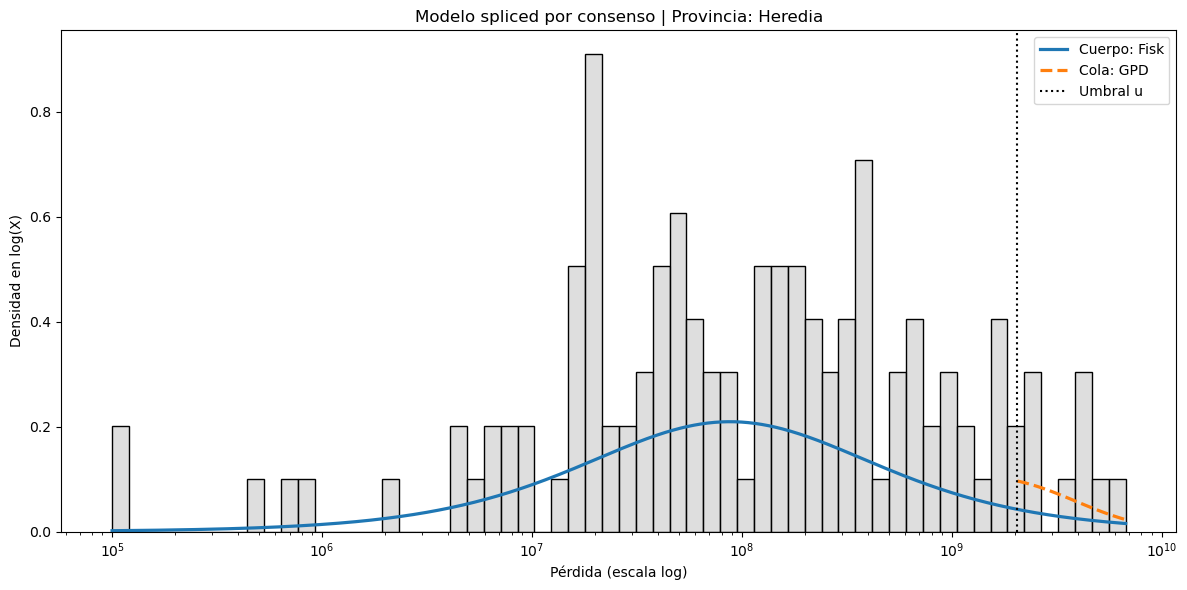

Análisis por consenso para la provincia Limón
La proporción de datos para  Limón es  0.054


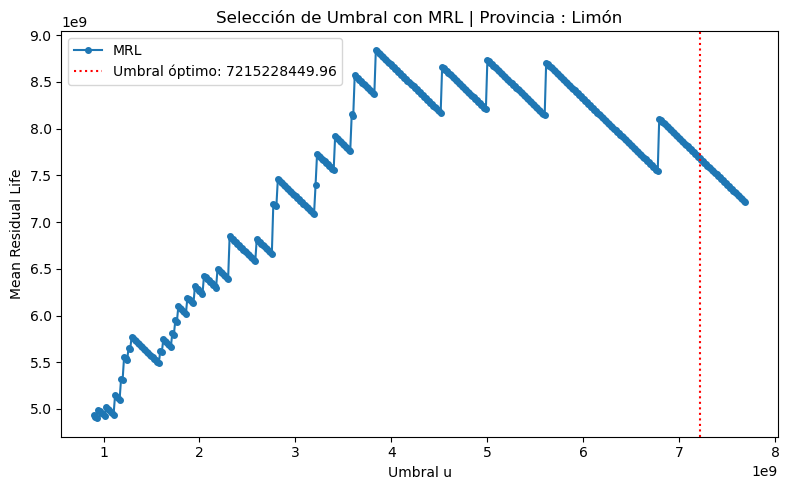

Umbral óptimo: 7,215,228,449.96


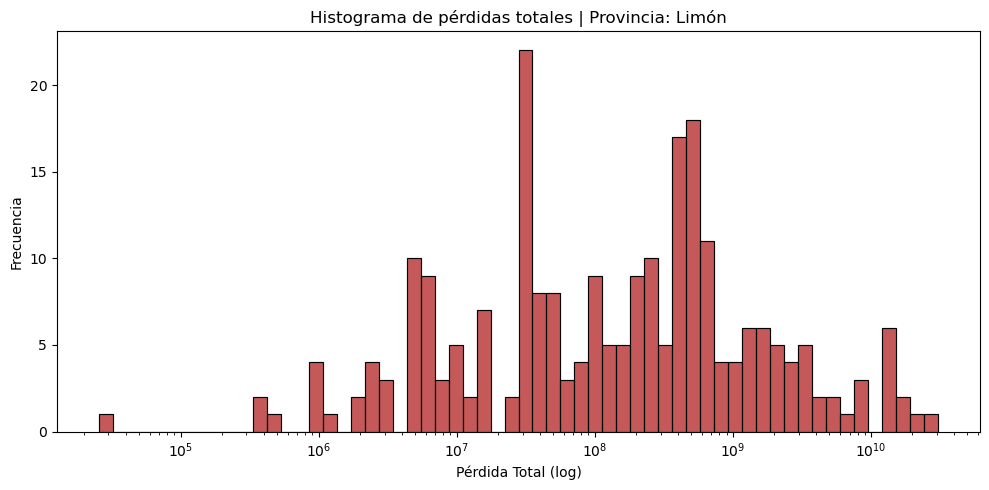

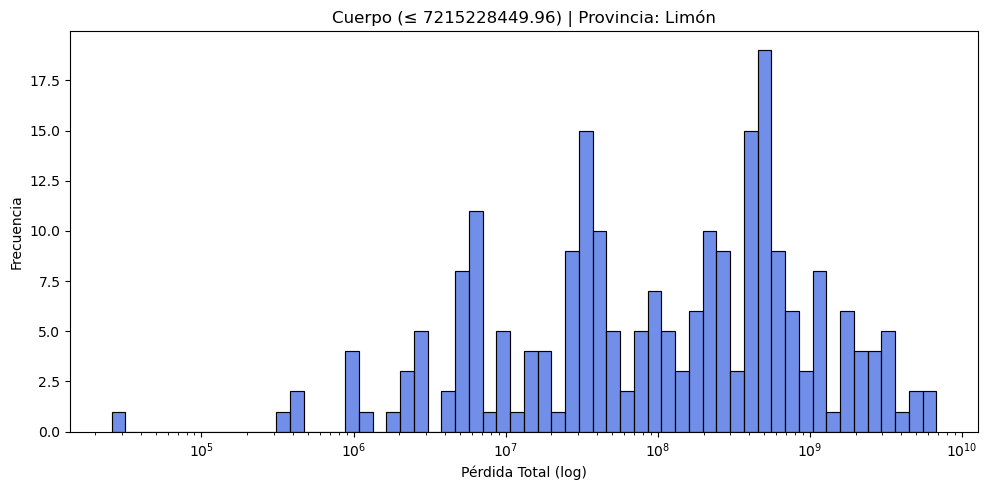

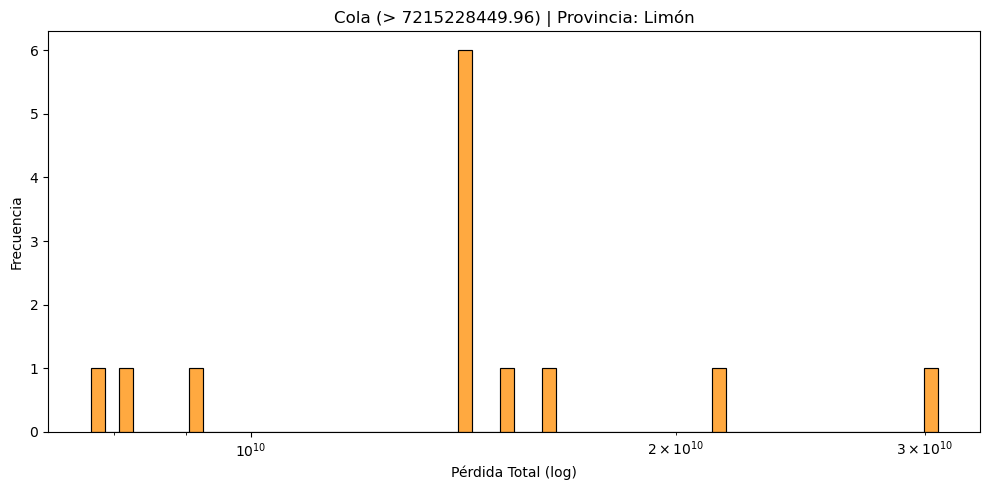

Tamaño cuerpo: 229 | Tamaño cola: 13 | Proporción cola: 0.054

 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.00

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.13

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.72

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.25

Resumen métricas cuerpo:
      modelo           WAIC            DIC           KS_p           AD  \
2  Lognormal    9463.436192    9463.390037   4.167789e-02     1.976055   
3       Fisk    9470.977490    9470.970611   4.449339e-02     3.087969   
1    Weibull    9478.154075    9478.123261   6.620434e-06    13.473307   
0      Gamma  412293.869796  412293.869796  2.010130e-250  4295.246128   

   rank_mediana  
2           1.0  
3           2.0  
1           3.0  
0           4.0  

Modelo seleccionado para el cuerpo: Lognormal


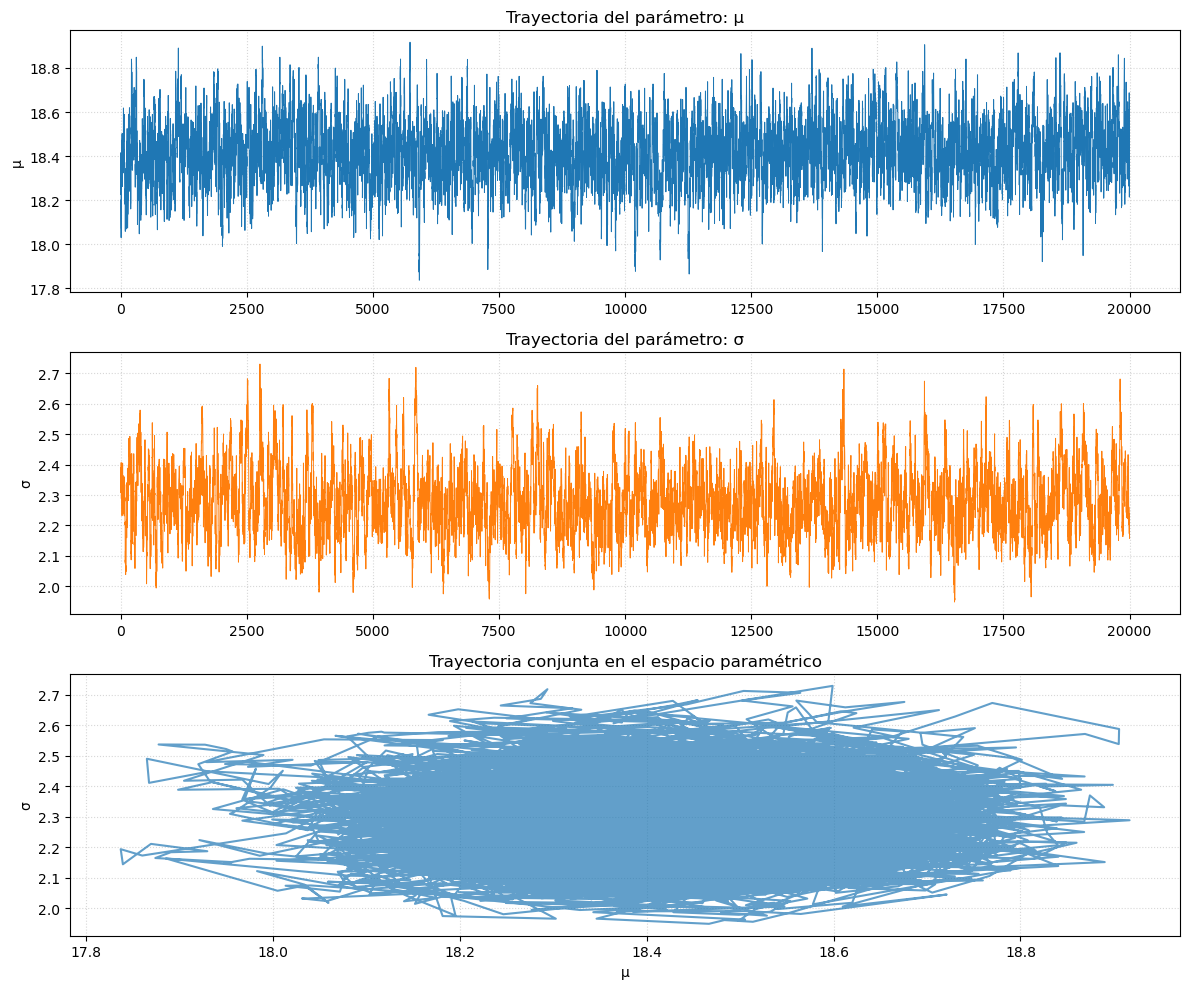


 Ajustando cola: GPD
Tasa aceptación GPD: 0.72

 Ajustando cola: Burr
Tasa aceptación Burr: 0.75

 Ajustando cola: Pareto
Tasa aceptación Pareto: 0.85

 Ajustando cola: LN_tail
Tasa aceptación LN_tail: 0.95

Resumen métricas cola:
    modelo        WAIC      KS_p        AD  rank_mediana
0      GPD  619.117375  0.054551  1.047362           1.0
1     Burr  623.800553  0.024273  1.390423           2.0
3  LN_tail  623.073969  0.021492  1.506133           3.0
2   Pareto  624.000235  0.009116  1.838109           4.0

Modelo seleccionado para la cola: GPD


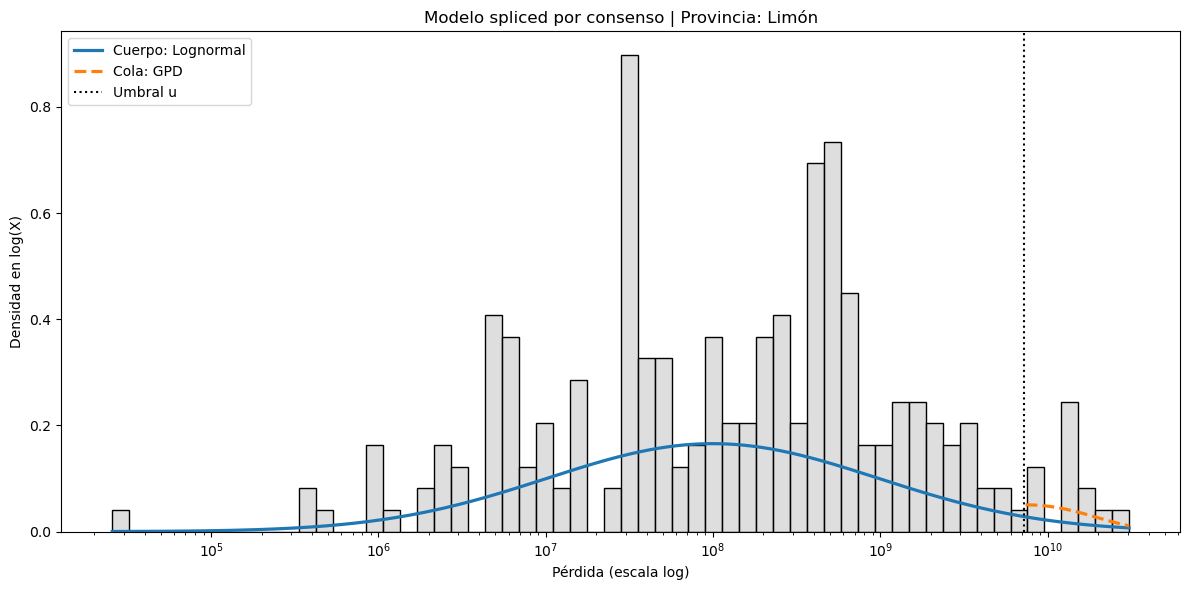

Análisis por consenso para la provincia San José
La proporción de datos para  San José es  0.110


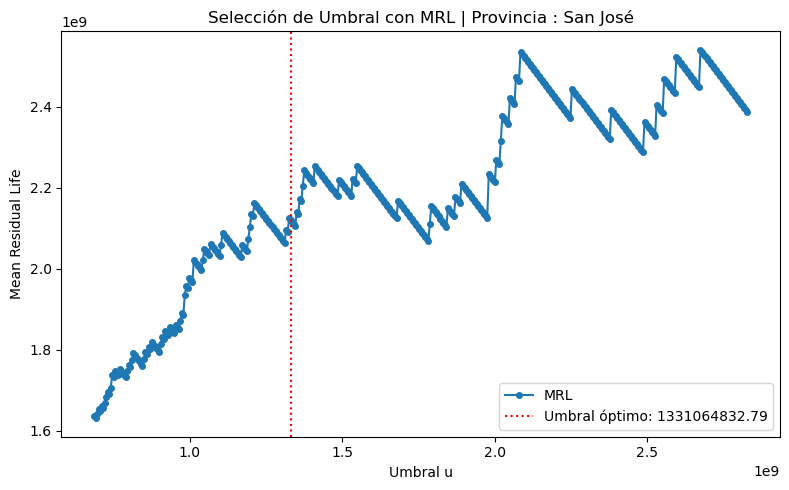

Umbral óptimo: 1,331,064,832.79


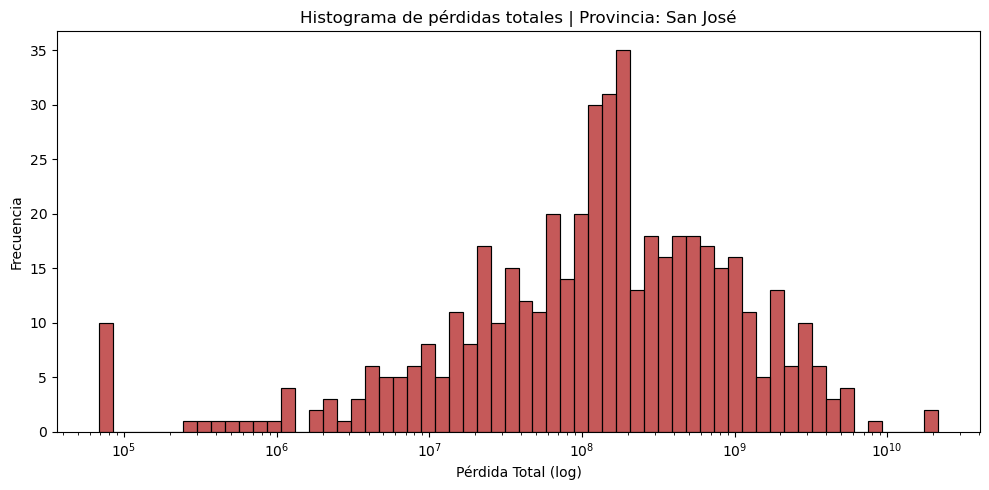

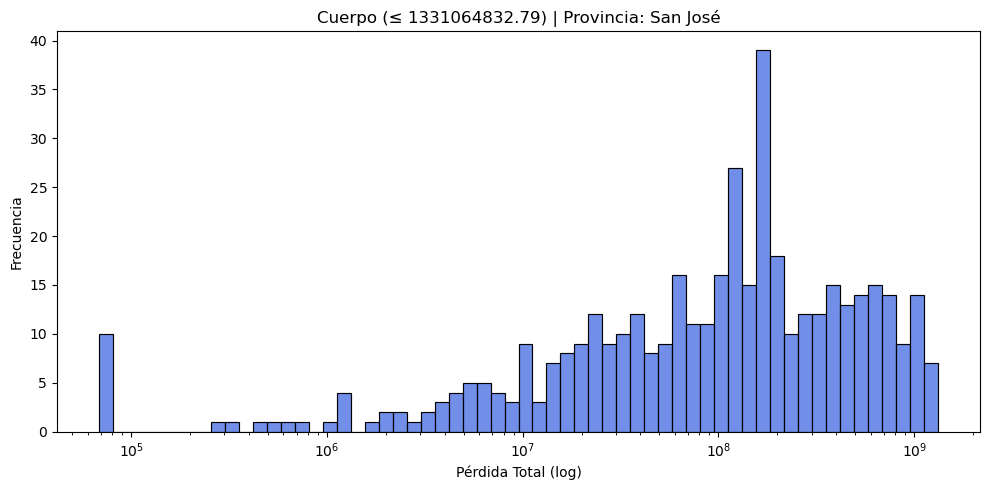

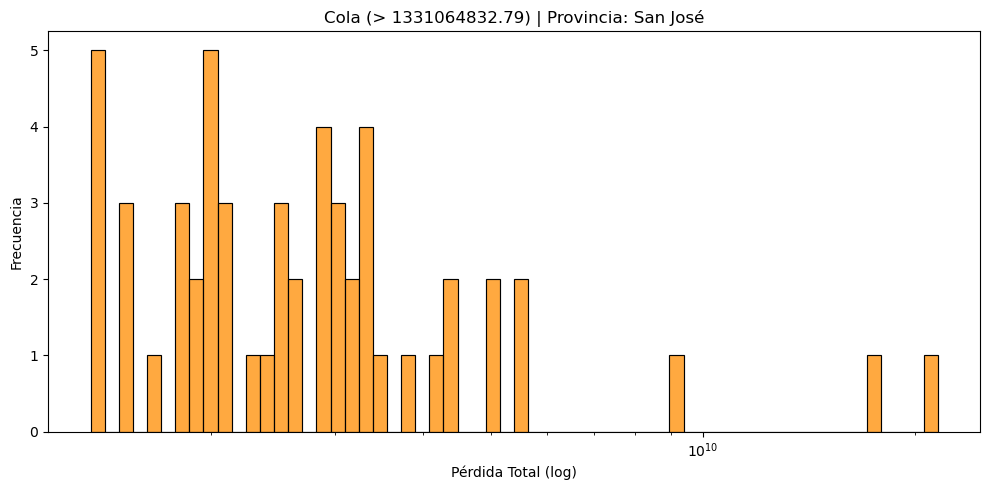

Tamaño cuerpo: 437 | Tamaño cola: 54 | Proporción cola: 0.110

 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.00

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.13

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.59

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.24

Resumen métricas cuerpo:
      modelo          WAIC           DIC          KS_p            AD  \
3       Fisk  1.770229e+04  1.770227e+04  9.633728e-04      7.195695   
1    Weibull  1.765178e+04  1.765177e+04  3.845930e-10     21.606952   
2  Lognormal  1.773863e+04  1.773851e+04  2.691610e-05      9.531369   
0      Gamma  4.243258e+10  1.821515e+07  0.000000e+00  10988.259851   

   rank_mediana  
3           1.5  
1           2.0  
2           2.5  
0           4.0  

Modelo seleccionado para el cuerpo: Fisk


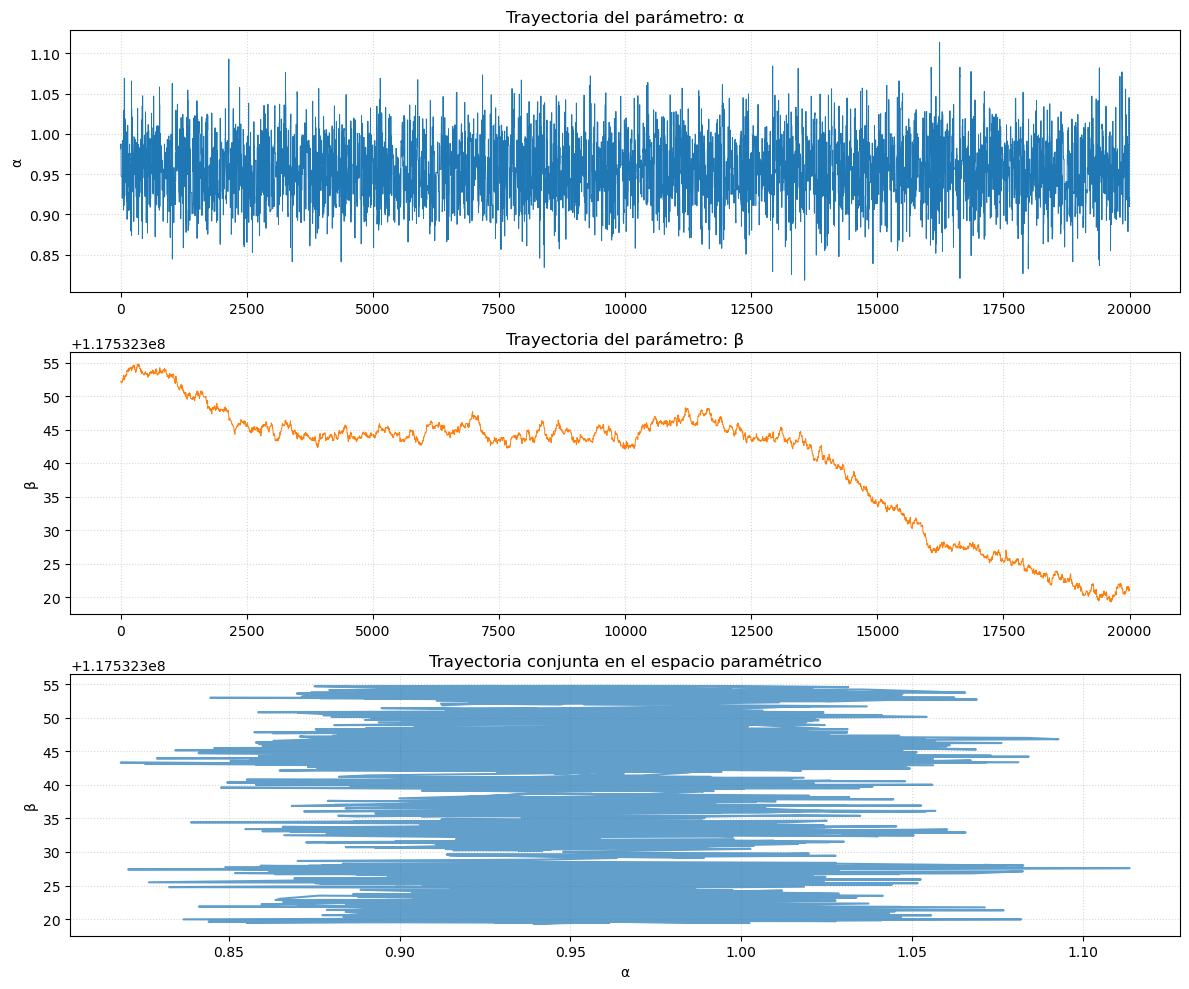


 Ajustando cola: GPD
Tasa aceptación GPD: 0.62

 Ajustando cola: Burr
Tasa aceptación Burr: 0.47

 Ajustando cola: Pareto
Tasa aceptación Pareto: 0.68

 Ajustando cola: LN_tail
Tasa aceptación LN_tail: 0.90

Resumen métricas cola:
    modelo         WAIC      KS_p        AD  rank_mediana
1     Burr  2423.462162  0.554943  0.869137           1.0
3  LN_tail  2422.676887  0.142698  1.453471           2.0
2   Pareto  2424.432901  0.068755  1.903353           3.0
0      GPD  2424.595738  0.023676  2.591904           4.0

Modelo seleccionado para la cola: Burr


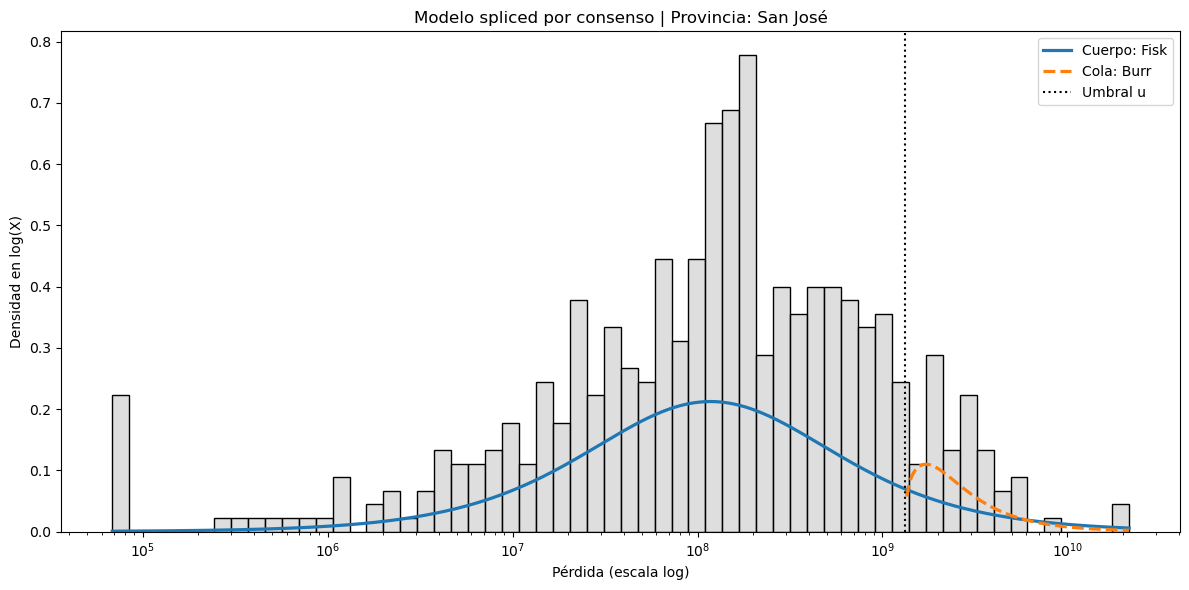

Análisis por consenso para la provincia Alajuela
La proporción de datos para  Alajuela es  0.057


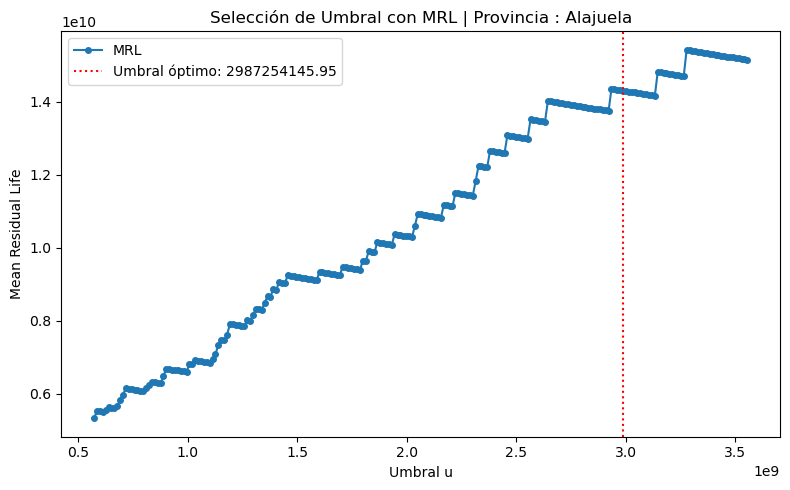

Umbral óptimo: 2,987,254,145.95


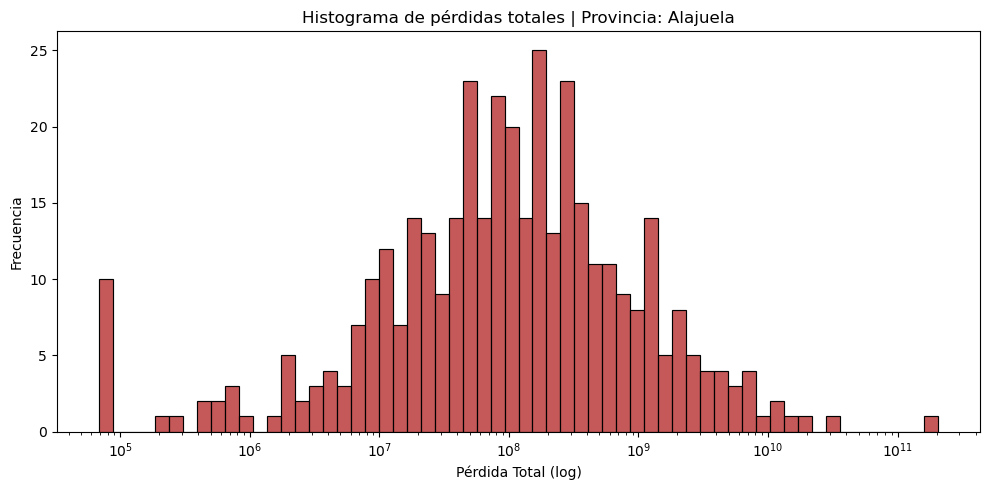

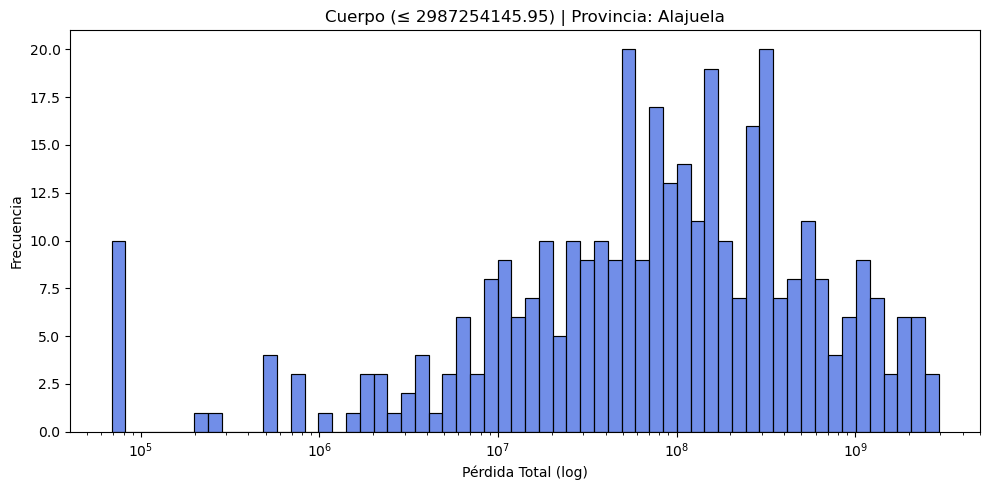

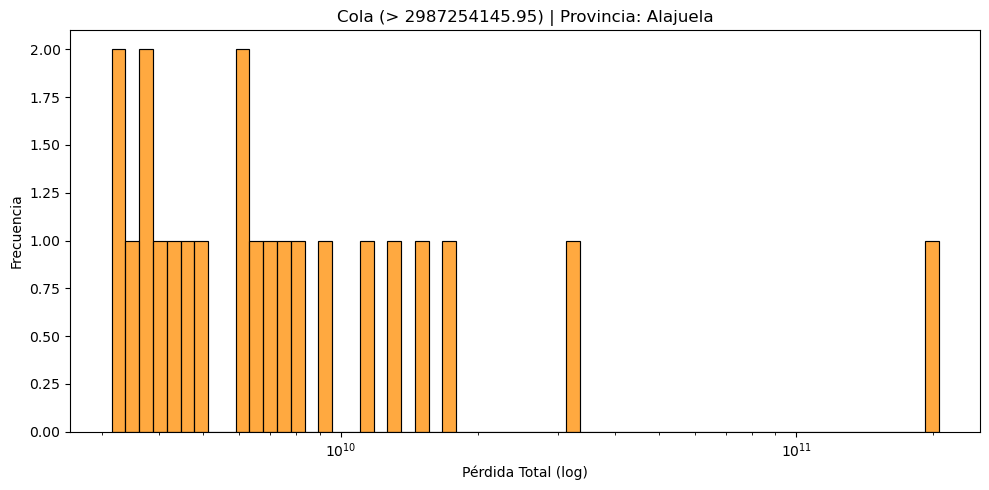

Tamaño cuerpo: 364 | Tamaño cola: 22 | Proporción cola: 0.057

 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.00

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.11

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.65

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.23

Resumen métricas cuerpo:
      modelo          WAIC            DIC          KS_p           AD  \
3       Fisk  1.474133e+04   14741.315608  2.574289e-01     2.325553   
1    Weibull  1.475323e+04   14753.205332  2.982837e-09    24.755469   
2  Lognormal  1.476236e+04   14762.297733  1.342545e-02     4.528181   
0      Gamma  1.871952e+08  950644.271439  0.000000e+00  7710.957692   

   rank_mediana  
3           1.0  
1           2.5  
2           2.5  
0           4.0  

Modelo seleccionado para el cuerpo: Fisk


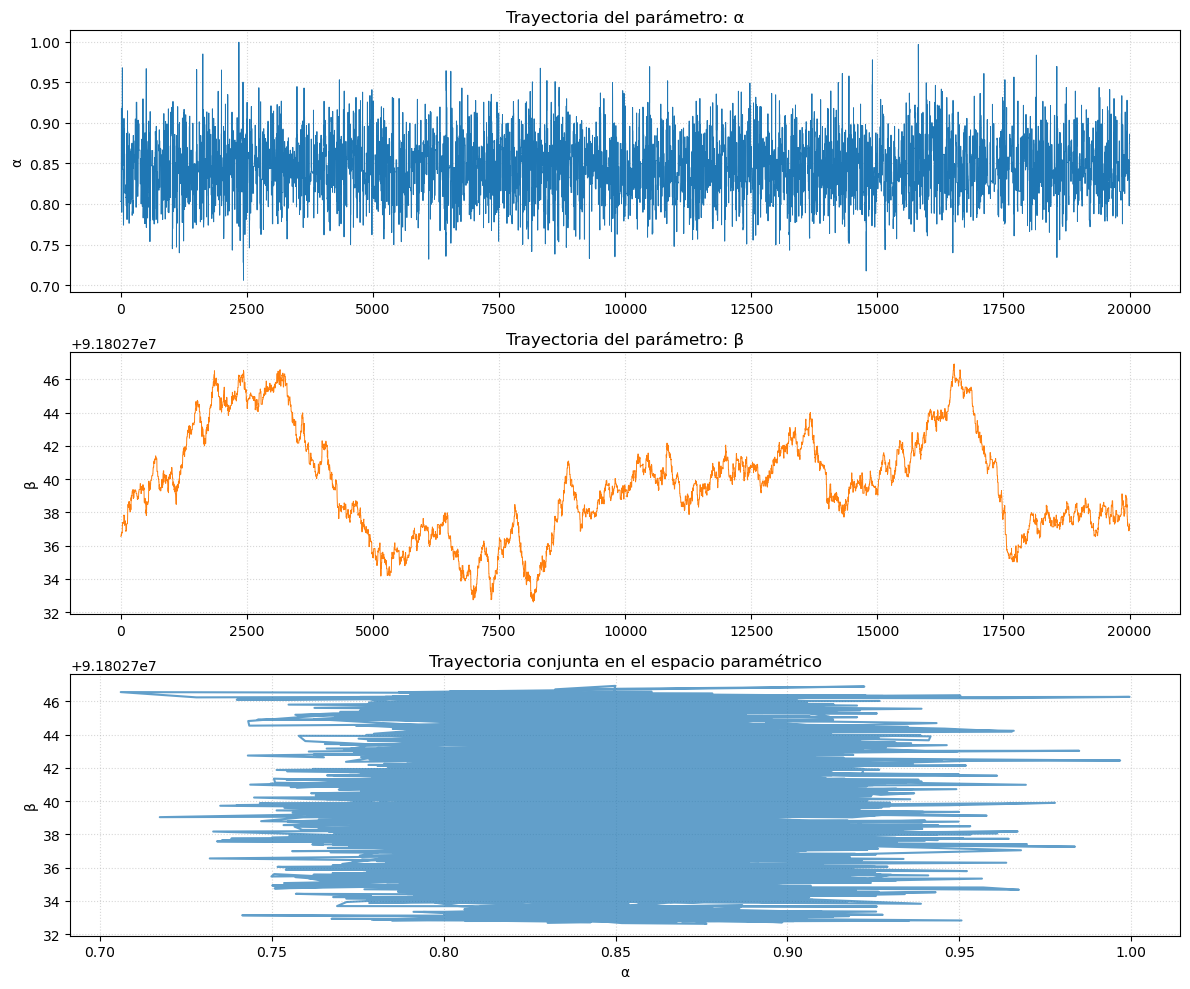


 Ajustando cola: GPD
Tasa aceptación GPD: 0.76

 Ajustando cola: Burr
Tasa aceptación Burr: 0.57

 Ajustando cola: Pareto
Tasa aceptación Pareto: 0.75

 Ajustando cola: LN_tail
Tasa aceptación LN_tail: 0.92

Resumen métricas cola:
    modelo         WAIC      KS_p        AD  rank_mediana
1     Burr  1048.802149  0.994801  0.141216           1.0
2   Pareto  1047.010245  0.961508  0.189358           2.0
3  LN_tail  1047.133042  0.974003  0.189625           2.0
0      GPD  1063.488108  0.000592  8.214209           4.0

Modelo seleccionado para la cola: Burr


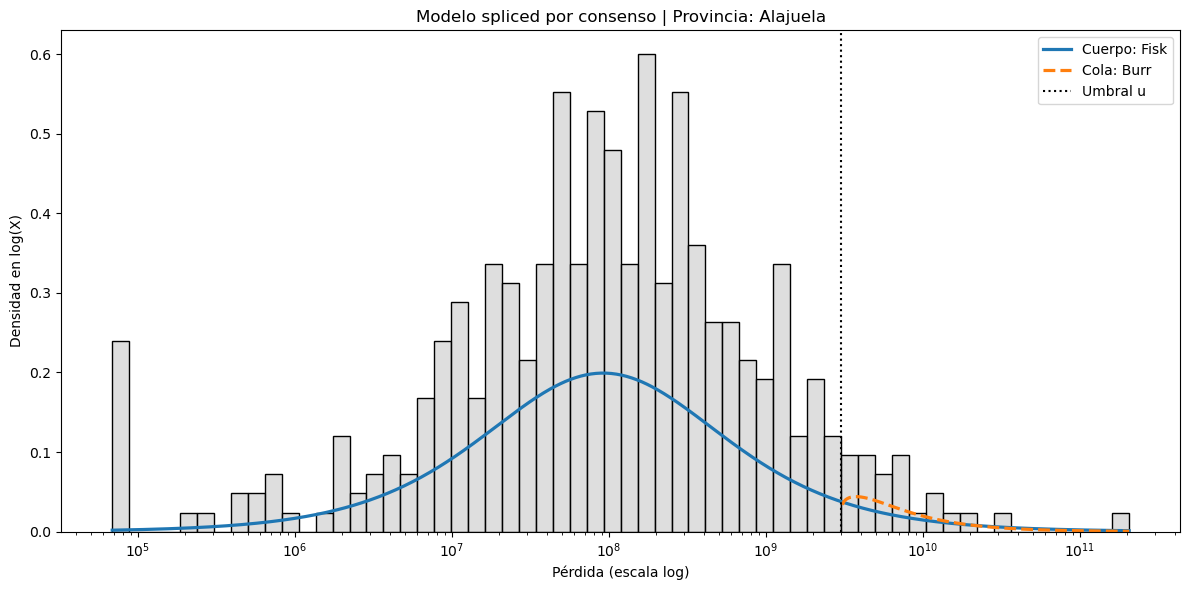

Análisis por consenso para la provincia Guanacaste
La proporción de datos para  Guanacaste es  0.086


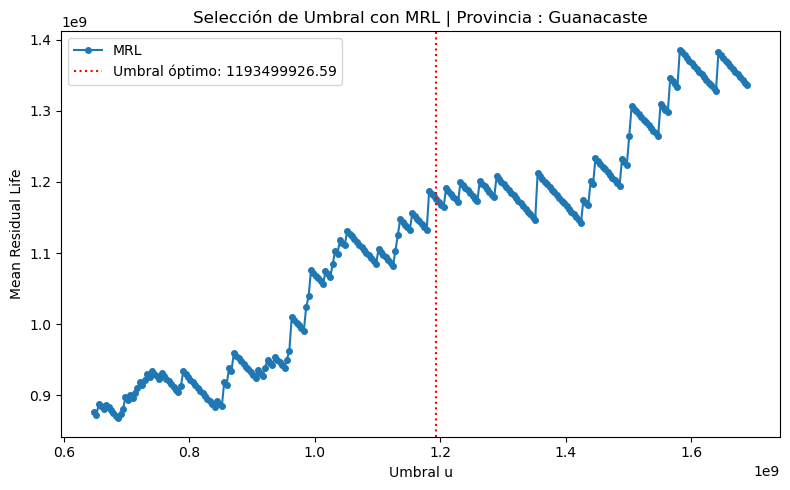

Umbral óptimo: 1,193,499,926.59


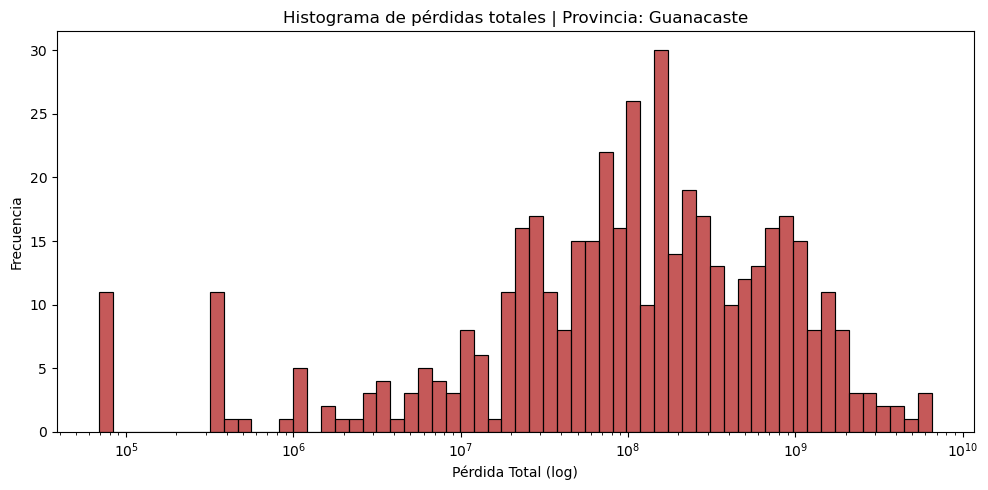

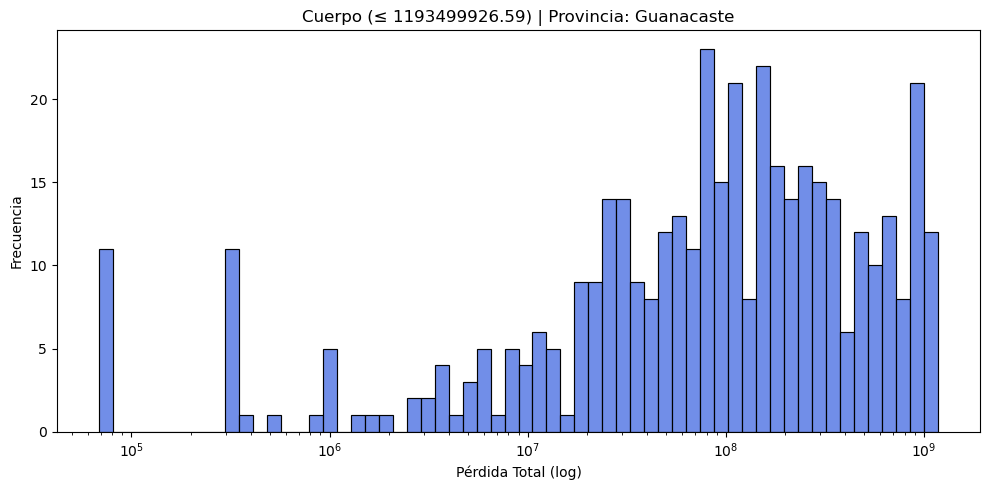

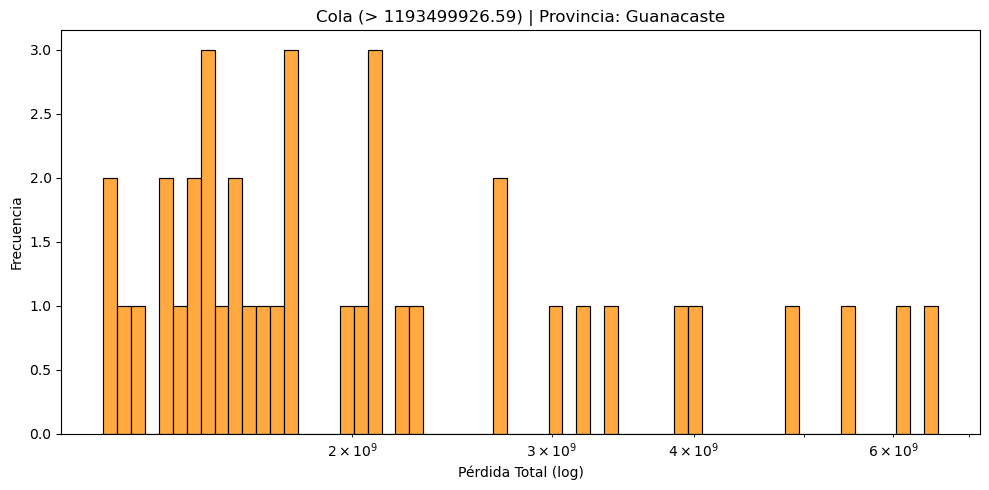

Tamaño cuerpo: 417 | Tamaño cola: 39 | Proporción cola: 0.086

 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.00

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.12

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.62

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.23

Resumen métricas cuerpo:
      modelo          WAIC           DIC          KS_p            AD  \
3       Fisk  1.683438e+04  1.683436e+04  3.714216e-04      6.780905   
1    Weibull  1.678759e+04  1.678759e+04  8.255272e-10     24.720216   
2  Lognormal  1.687153e+04  1.687144e+04  1.097622e-04     11.337508   
0      Gamma  2.699586e+10  9.414804e+06  0.000000e+00  10109.520293   

   rank_mediana  
3           1.5  
1           2.0  
2           2.5  
0           4.0  

Modelo seleccionado para el cuerpo: Fisk


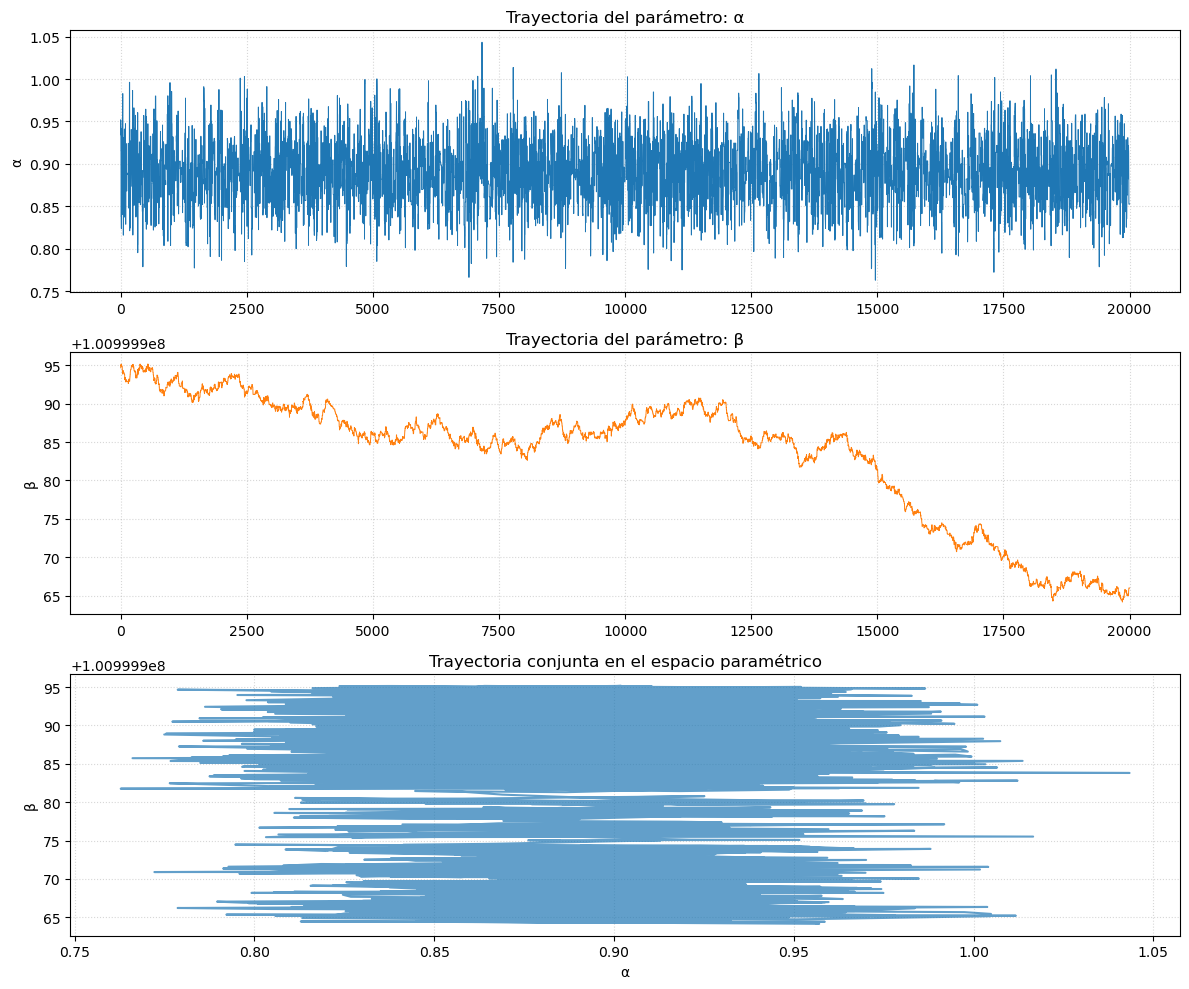


 Ajustando cola: GPD
Tasa aceptación GPD: 0.67

 Ajustando cola: Burr
Tasa aceptación Burr: 0.49

 Ajustando cola: Pareto
Tasa aceptación Pareto: 0.68

 Ajustando cola: LN_tail
Tasa aceptación LN_tail: 0.11

Resumen métricas cola:
    modelo         WAIC          KS_p          AD  rank_mediana
1     Burr  1711.006658  9.666382e-01    0.284234           1.0
0      GPD  1708.309408  2.509204e-01    0.943977           2.0
2   Pareto  1712.906851  1.770614e-01    1.250280           3.0
3  LN_tail  1680.877648  4.167177e-11  502.993290           4.0

Modelo seleccionado para la cola: Burr


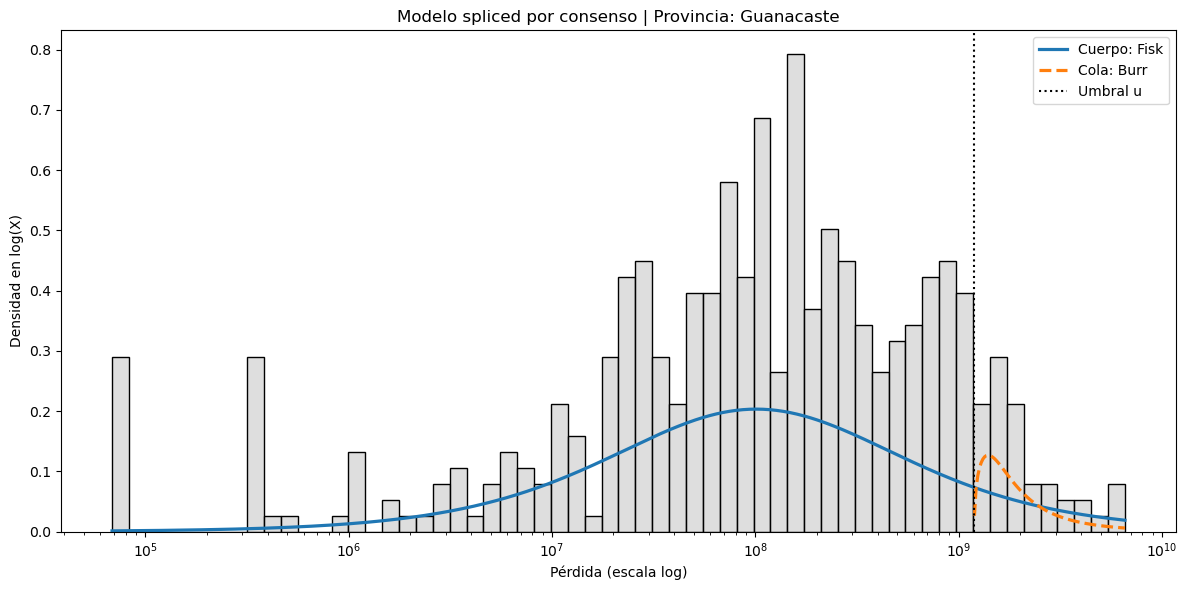

Análisis por consenso para la provincia Puntarenas
La proporción de datos para  Puntarenas es  0.080


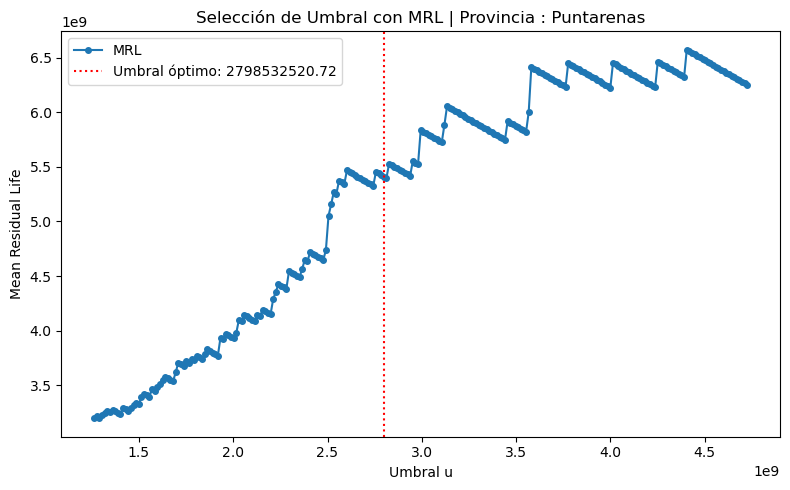

Umbral óptimo: 2,798,532,520.72


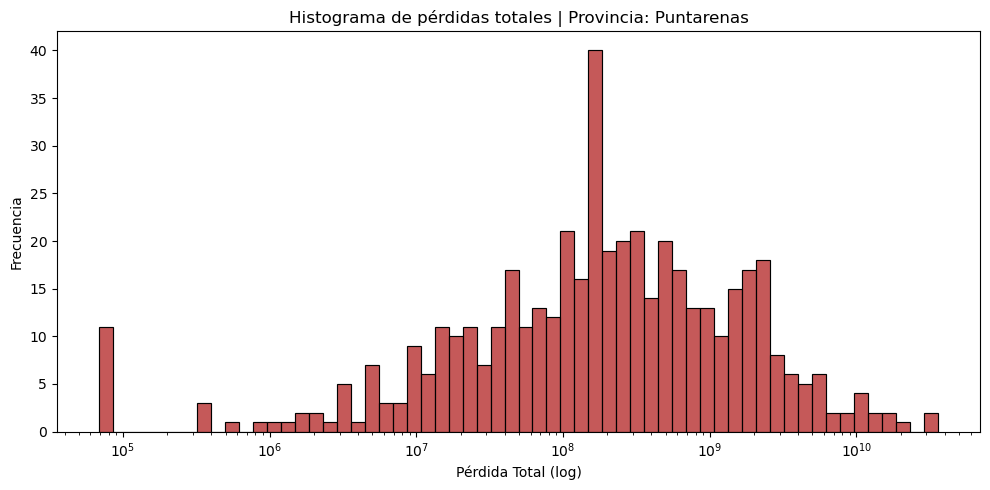

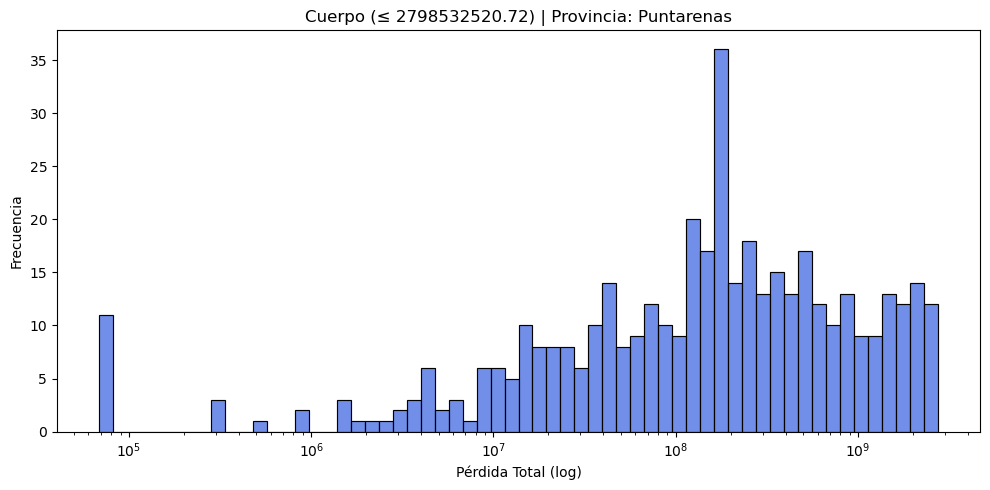

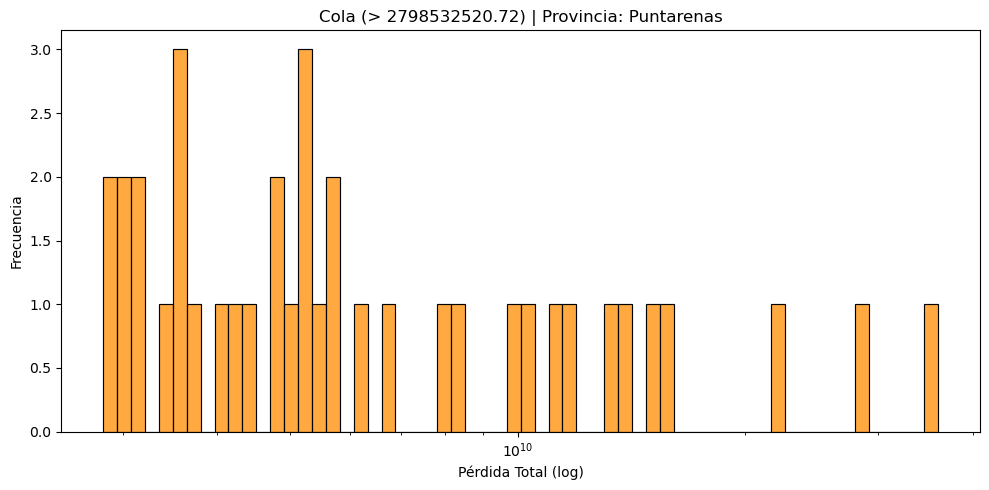

Tamaño cuerpo: 436 | Tamaño cola: 38 | Proporción cola: 0.080

 Ajustando cuerpo: Gamma
Tasa de aceptación Gamma: 0.00

 Ajustando cuerpo: Weibull
Tasa de aceptación Weibull: 0.11

 Ajustando cuerpo: Lognormal
Tasa de aceptación Lognormal: 0.62

 Ajustando cuerpo: Fisk
Tasa de aceptación Fisk: 0.21

Resumen métricas cuerpo:
      modelo           WAIC            DIC          KS_p           AD  \
3       Fisk   18101.300423   18101.290287  4.425679e-03     4.411611   
1    Weibull   18084.519040   18084.508856  3.153682e-12    27.223014   
2  Lognormal   18134.152497   18134.037336  6.949367e-05     7.186789   
0      Gamma  936741.055053  936741.055053  0.000000e+00  9495.691123   

   rank_mediana  
3           1.5  
1           2.0  
2           2.5  
0           4.0  

Modelo seleccionado para el cuerpo: Fisk


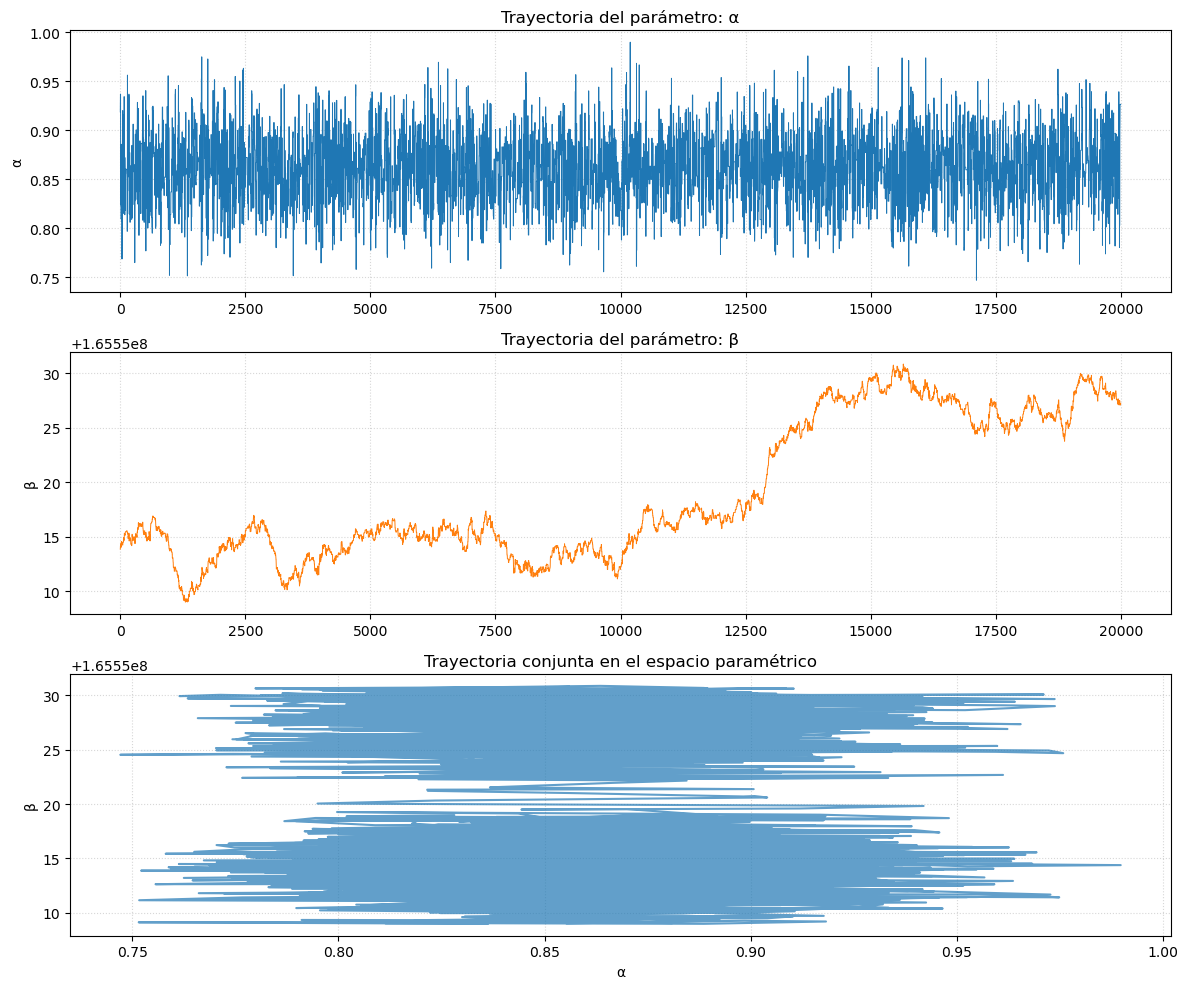


 Ajustando cola: GPD
Tasa aceptación GPD: 0.69

 Ajustando cola: Burr
Tasa aceptación Burr: 0.48

 Ajustando cola: Pareto
Tasa aceptación Pareto: 0.68

 Ajustando cola: LN_tail
Tasa aceptación LN_tail: 0.92

Resumen métricas cola:
    modelo         WAIC      KS_p        AD  rank_mediana
3  LN_tail  1777.249472  0.778714  0.352159           1.0
1     Burr  1779.932759  0.849240  0.356622           2.0
2   Pareto  1778.392090  0.617873  0.488139           3.0
0      GPD  1779.449086  0.062953  2.063065           4.0

Modelo seleccionado para la cola: LN_tail


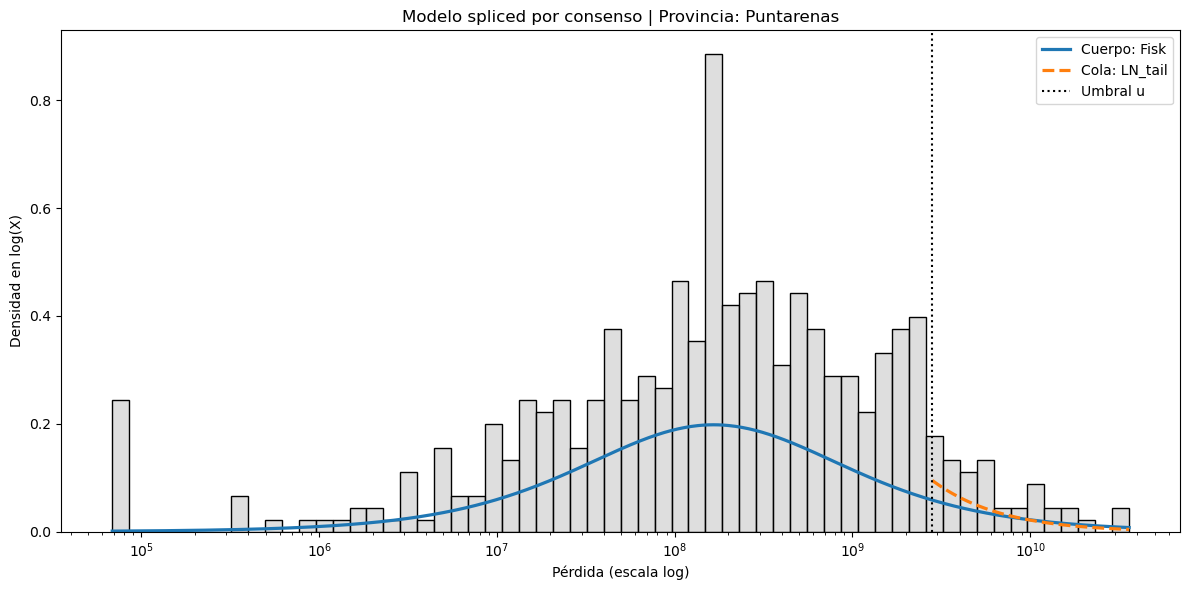

In [47]:
resultados_provincia = {}
for name in df['provincia'].unique():
    res = pipeline_categoria_consenso(df, provincia=name,
                                     n_iter=50000, burn=30000)
    resultados_provincia[name] = res
    guardar_resultados_csv(name, res, carpeta="../res/csv_provincias")